# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

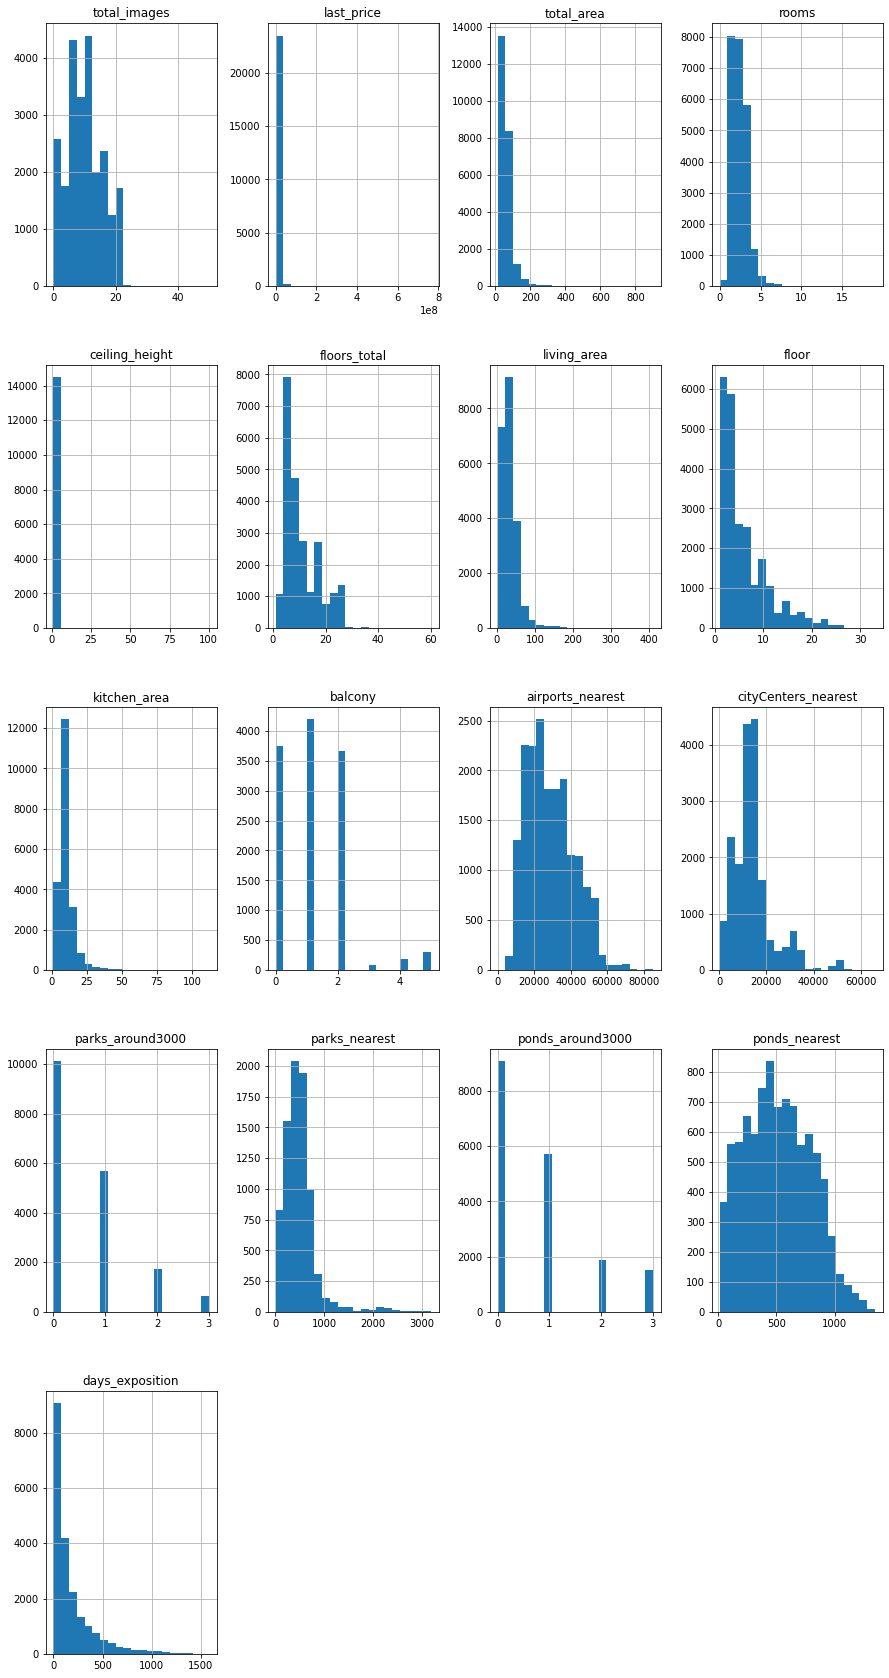

In [5]:
data.hist(figsize=(15,30 ), bins=20)
plt.show()

Большая часть гистограмм "тяготеет" к небольшим значениям по оси Х. Это свидетельствует о том, что статистически большая часть рассматриваемых показателей имеет малые значения в разрезе того или иного критерия, а также о том, что значение по тому или иному параметру могут быть пропущены. До этапа предобработки данных можно предположить, что большинство продаваемых оъектов имеют относительно близкие характеристики в разрезе параметров. Если бы это было не так, то графики бы имели более ровную форму.

### Выполните предобработку данных

Представляется сомнительным, чтобы цена за квартиру была с копейками, поэтому меняем формат в колонке 'last_price' на целые числа

In [6]:
data['last_price'] = data['last_price'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  int64  
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Меняем формат отображения даты размещения на стандартный для лучшей читабельности и отображения по дате без часов  

In [7]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

Из информации по таблице понимаем, что значительная часть данных по высоте потолков (ceiling_height) не заполнена. Необходимо восстановить. Строим предположение, что в целом можно брать либо среднее значение от количества этажей в доме по высоте потолка, либо медианное. Для этого сравним два этих показателя.

In [8]:
data.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['mean', 'median'])

,mean,median
,ceiling_height,ceiling_height
floors_total,,
1.0,2.740000,2.80
2.0,3.006791,2.70
3.0,2.969474,2.80
4.0,2.986831,3.00
5.0,2.793191,2.55
6.0,3.120743,3.00
7.0,2.946960,3.00
8.0,2.856818,2.80


В целом среднее и медианное значение близки, поэтому будем заменять на медианное, но смущают показатели для зданий высотой в 36 и 37 этажей. Посмотрим их отдельно.

In [9]:
print(data.query('(floors_total==36.0) '))

       total_images  last_price  total_area first_day_exposition  rooms  \
397              15     5990000        54.0           2018-03-22      2   
5807             17     8150000        80.0           2019-01-09      2   
11079            16     9200000        75.0           2019-02-22      2   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
397               NaN          36.0         21.4     28          NaN  ...   
5807             27.0          36.0         41.0     13          NaN  ...   
11079             2.7          36.0         40.0     29          NaN  ...   

       kitchen_area  balcony    locality_name  airports_nearest  \
397            18.7      1.0  Санкт-Петербург           18732.0   
5807           12.0      5.0  Санкт-Петербург           18732.0   
11079          12.0      2.0  Санкт-Петербург           18732.0   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
397               20444.0               0

По 36 этажам понимаем, что скорее всего допущена опечатка и вместо 2,7, поставили цифру 27 в 5807 строке. Заменяем на корректную и проверяем

In [10]:
data.loc[5807,'ceiling_height']=2.7
print(data.query('(floors_total==36.0) '))

       total_images  last_price  total_area first_day_exposition  rooms  \
397              15     5990000        54.0           2018-03-22      2   
5807             17     8150000        80.0           2019-01-09      2   
11079            16     9200000        75.0           2019-02-22      2   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
397               NaN          36.0         21.4     28          NaN  ...   
5807              2.7          36.0         41.0     13          NaN  ...   
11079             2.7          36.0         40.0     29          NaN  ...   

       kitchen_area  balcony    locality_name  airports_nearest  \
397            18.7      1.0  Санкт-Петербург           18732.0   
5807           12.0      5.0  Санкт-Петербург           18732.0   
11079          12.0      2.0  Санкт-Петербург           18732.0   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
397               20444.0               0

In [11]:
print(data.query('(floors_total==37.0) '))

       total_images  last_price  total_area first_day_exposition  rooms  \
16934             5     4100000        40.0           2017-10-17      1   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
16934            1.75          37.0         17.4      5          NaN  ...   

       kitchen_area  balcony    locality_name  airports_nearest  \
16934          8.34      NaN  Санкт-Петербург           18732.0   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
16934             20444.0               0.0            NaN               3.0   

       ponds_nearest  days_exposition  
16934           80.0             71.0  

[1 rows x 22 columns]


По 37 этажу видим, что запись одна и, скорее всего, опечатались и написали вместо 2,75 высоту в 1,75. Исправляем и проверяем.

In [12]:
data.loc[16934,'ceiling_height']=2.75
print(data.query('(floors_total==37.0) '))

       total_images  last_price  total_area first_day_exposition  rooms  \
16934             5     4100000        40.0           2017-10-17      1   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
16934            2.75          37.0         17.4      5          NaN  ...   

       kitchen_area  balcony    locality_name  airports_nearest  \
16934          8.34      NaN  Санкт-Петербург           18732.0   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
16934             20444.0               0.0            NaN               3.0   

       ponds_nearest  days_exposition  
16934           80.0             71.0  

[1 rows x 22 columns]


Проверем остальные уникальные значения высот потолков

In [13]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

Выявлены следующие ошибочные значения: 25,2,8,27,24,26,1.2,14,20,1,100,10.3,32,27.5,22.6. С помощью запроса просмотрим строки подробно

In [14]:
data.query('ceiling_height in [25,2,8,27,24,26,1.2,14,20,1,100,10.3,32,27.5,22.6]')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000,55.20,2018-07-12,2,25.0,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
552,11,2999000,33.50,2017-03-30,1,2.0,15.0,17.5,6,NaN,...,6.5,NaN,Санкт-Петербург,33972.0,11746.0,1.0,520.0,1.0,949.0,270.0
2572,4,2400000,62.00,2018-12-27,3,2.0,5.0,40.0,4,NaN,...,6.0,1.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3148,14,2900000,75.00,2018-11-12,3,32.0,3.0,53.0,2,NaN,...,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3474,3,1400000,30.00,2018-03-16,1,8.0,5.0,15.3,2,False,...,7.3,NaN,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
4212,1,2120000,35.43,2017-12-18,1,2.0,18.0,16.6,9,NaN,...,8.8,2.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0
4643,0,4300000,45.00,2018-02-01,2,25.0,9.0,30.0,2,NaN,...,7.0,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000,25.00,2017-09-27,0,27.0,25.0,17.0,17,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5076,0,3850000,30.50,2018-10-03,1,24.0,5.0,19.5,1,True,...,5.5,NaN,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0
5246,0,2500000,54.00,2017-10-13,2,27.0,5.0,30.0,3,NaN,...,9.0,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0


Скорректируем значения там, где это возможно

In [15]:
data['ceiling_height']=data['ceiling_height'].replace(25,2.5)
data['ceiling_height']=data['ceiling_height'].replace(27,2.7)
data['ceiling_height']=data['ceiling_height'].replace(24,2.4)
data['ceiling_height']=data['ceiling_height'].replace(26,2.6)
data['ceiling_height']=data['ceiling_height'].replace(32,3.2)
data['ceiling_height']=data['ceiling_height'].replace(27.5,2.75)
data['ceiling_height']=data['ceiling_height'].replace(22.6,2.26)
data.query('ceiling_height in [25,2,8,27,24,26,1.2,14,20,1,100,10.3,32,27.5,22.6]')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
552,11,2999000,33.50,2017-03-30,1,2.0,15.0,17.5,6,NaN,...,6.5,NaN,Санкт-Петербург,33972.0,11746.0,1.0,520.0,1.0,949.0,270.0
2572,4,2400000,62.00,2018-12-27,3,2.0,5.0,40.0,4,NaN,...,6.0,1.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3474,3,1400000,30.00,2018-03-16,1,8.0,5.0,15.3,2,False,...,7.3,NaN,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
4212,1,2120000,35.43,2017-12-18,1,2.0,18.0,16.6,9,NaN,...,8.8,2.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0
5712,5,1500000,42.80,2017-08-14,2,1.2,2.0,27.5,1,NaN,...,5.2,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
5850,9,1650000,35.50,2018-05-29,1,2.0,5.0,NaN,5,NaN,...,NaN,NaN,Луга,NaN,NaN,NaN,NaN,NaN,NaN,100.0
11352,4,3300000,36.00,2017-06-18,1,2.0,17.0,15.2,12,NaN,...,10.1,0.0,посёлок Металлострой,25268.0,26980.0,0.0,NaN,0.0,NaN,53.0
15061,19,5600000,56.40,2018-05-11,2,14.0,14.0,32.4,5,NaN,...,9.1,2.0,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0
15743,14,5600000,67.00,2016-11-11,3,8.0,16.0,41.0,1,NaN,...,8.0,NaN,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0
16446,6,12300000,88.30,2019-03-12,3,2.0,5.0,63.9,2,NaN,...,12.0,NaN,Санкт-Петербург,38415.0,7675.0,1.0,568.0,1.0,154.0,NaN


Оставшиеся 20 строк удаляем

In [16]:
del_data=[]
for d in range(len(data['ceiling_height'])):
    if data.loc[d,'ceiling_height'] in [25,2,8,27,24,26,1.2,14,20,1,100,10.3,32,27.5,22.6]:
        del_data.append(d)
data=data.drop(del_data)

In [17]:
data=data.reset_index(drop=True)

Обновляем таблицу со значениями

In [18]:
data.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['mean', 'median'])

,mean,median
,ceiling_height,ceiling_height
floors_total,,
1.0,2.740000,2.80
2.0,2.791831,2.70
3.0,2.897293,2.80
4.0,2.956033,3.00
5.0,2.708759,2.55
6.0,3.074216,3.00
7.0,2.946960,3.00
8.0,2.856818,2.80


Обновляем информацию по высоте потолков по медиане в зависимости от этажности дома

In [19]:
for d in data['floors_total'].unique():
    data.loc[(data['floors_total']==d)&(data['ceiling_height'].isna()), 'ceiling_height']=data.loc[(data['floors_total']==d),'ceiling_height'].median()

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [20]:
data.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['mean', 'median'])

,mean,median
,ceiling_height,ceiling_height
floors_total,,
1.0,2.776000,2.80
2.0,2.751339,2.70
3.0,2.858114,2.80
4.0,2.971092,3.00
5.0,2.650474,2.55
6.0,3.050263,3.00
7.0,2.964341,3.00
8.0,2.832051,2.80


Проверяем, остались ли в списке пустые значения

In [21]:
data[data['ceiling_height'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000,65.20,2018-10-02,2,NaN,NaN,30.80,4,NaN,...,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033,28.10,2016-11-23,1,NaN,NaN,20.75,1,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348,70.80,2015-08-01,2,NaN,NaN,38.40,12,NaN,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
670,4,6051191,93.60,2017-04-06,3,NaN,NaN,47.10,8,NaN,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1756,5,3600000,39.00,2017-04-22,1,NaN,NaN,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21257,3,6300000,70.02,2015-03-28,2,NaN,NaN,34.87,19,NaN,...,10.13,0.0,Санкт-Петербург,35234.0,14674.0,0.0,NaN,1.0,844.0,516.0
21737,7,6800000,57.00,2017-05-01,2,NaN,NaN,NaN,21,NaN,...,NaN,0.0,Санкт-Петербург,17618.0,14600.0,2.0,104.0,0.0,NaN,36.0
22638,4,4574160,64.50,2017-04-02,2,NaN,NaN,31.70,20,NaN,...,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22790,0,14569263,110.40,2016-11-20,3,NaN,NaN,45.38,6,NaN,...,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0


Удаляем пустые значения

In [22]:
data = data.dropna(subset = ['ceiling_height'])

Переходим к количеству этажей (floors_total). В списке есть небольшое количество пропусков, потому их можно удалить

In [23]:
data = data.dropna(subset = ['floors_total'])

Число этажей - всегда целое. Выше мы посмотрели, что "не целых" этажей нет, поэтому меняем формат чисел в столбце

In [24]:
data['floors_total'] = data['floors_total'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23592 entries, 0 to 23678
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23592 non-null  int64         
 1   last_price            23592 non-null  int64         
 2   total_area            23592 non-null  float64       
 3   first_day_exposition  23592 non-null  datetime64[ns]
 4   rooms                 23592 non-null  int64         
 5   ceiling_height        23592 non-null  float64       
 6   floors_total          23592 non-null  int64         
 7   living_area           21724 non-null  float64       
 8   floor                 23592 non-null  int64         
 9   is_apartment          2771 non-null   object        
 10  studio                23592 non-null  bool          
 11  open_plan             23592 non-null  bool          
 12  kitchen_area          21365 non-null  float64       
 13  balcony         

Переходим к столбцу жилой площади (living_area). Пропущенные значения в нём будем восстанавливать по зависимости от статистики в общей площади (total_area)

In [25]:
data['living_area']=data['living_area'].fillna(0)

In [26]:
for d in data['total_area'].unique():
    data.loc[(data['total_area']==d)&(data['living_area']==0), 'living_area']=data.loc[(data['total_area']==d),'living_area'].median()

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23592 entries, 0 to 23678
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23592 non-null  int64         
 1   last_price            23592 non-null  int64         
 2   total_area            23592 non-null  float64       
 3   first_day_exposition  23592 non-null  datetime64[ns]
 4   rooms                 23592 non-null  int64         
 5   ceiling_height        23592 non-null  float64       
 6   floors_total          23592 non-null  int64         
 7   living_area           23592 non-null  float64       
 8   floor                 23592 non-null  int64         
 9   is_apartment          2771 non-null   object        
 10  studio                23592 non-null  bool          
 11  open_plan             23592 non-null  bool          
 12  kitchen_area          21365 non-null  float64       
 13  balcony         

Проверяем на наличие нулевых значений в столбце living_area, чтобы узнать, все ли значения были найдены

In [28]:
data[data['living_area']==0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
360,6,4990000,57.84,2018-08-22,2,2.65,27,0.0,13,NaN,...,10.19,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,60.0
801,5,8045000,73.08,2018-11-10,2,2.70,12,0.0,12,NaN,...,10.69,2.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,10.0
1306,20,26558000,152.38,2017-01-11,5,2.75,17,0.0,12,NaN,...,14.61,5.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,625.0
1387,20,59800000,399.00,2015-01-21,5,5.60,6,0.0,6,NaN,...,NaN,0.0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0
1463,6,21500000,122.50,2017-11-07,3,3.00,15,0.0,8,NaN,...,12.00,2.0,Санкт-Петербург,31744.0,4836.0,0.0,NaN,3.0,153.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22904,10,6552700,83.58,2018-02-20,3,2.70,21,0.0,5,NaN,...,10.15,NaN,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,428.0
22998,6,8555000,64.85,2019-04-24,2,3.10,14,0.0,13,NaN,...,11.70,2.0,Санкт-Петербург,37434.0,8460.0,1.0,441.0,2.0,427.0,NaN
23272,6,2980000,36.02,2018-07-26,1,2.65,27,0.0,27,NaN,...,9.26,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,72.0
23304,14,9900000,59.09,2018-06-10,1,3.30,5,0.0,5,NaN,...,17.44,NaN,Санкт-Петербург,25965.0,4754.0,0.0,NaN,2.0,776.0,178.0


Найдено 139 строк без обозначения жилой площади. Удаляем их, чтобы не портить статистику, т.к. их количество в общей массе не велико.

In [29]:
data=data[data['living_area']!=0]

In [30]:
data[data['living_area']==0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23453 entries, 0 to 23678
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23453 non-null  int64         
 1   last_price            23453 non-null  int64         
 2   total_area            23453 non-null  float64       
 3   first_day_exposition  23453 non-null  datetime64[ns]
 4   rooms                 23453 non-null  int64         
 5   ceiling_height        23453 non-null  float64       
 6   floors_total          23453 non-null  int64         
 7   living_area           23453 non-null  float64       
 8   floor                 23453 non-null  int64         
 9   is_apartment          2763 non-null   object        
 10  studio                23453 non-null  bool          
 11  open_plan             23453 non-null  bool          
 12  kitchen_area          21272 non-null  float64       
 13  balcony         

Переходим к столбцу is_apartment. Варианты заполнения данного столца должны иметь булев тип (либо да, либо нет). Смотрим уникальные значения столбца

In [32]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

В результате видим, что часть данных не заполнена. Скорее всего не заполнены значения "нет"(False), т.к. продавцы просто не выбирали его из списка. Заполним недостающие значения и проверим результат.

In [33]:
data['is_apartment']=data['is_apartment'].fillna(False)
data['is_apartment'].unique()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23453 entries, 0 to 23678
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23453 non-null  int64         
 1   last_price            23453 non-null  int64         
 2   total_area            23453 non-null  float64       
 3   first_day_exposition  23453 non-null  datetime64[ns]
 4   rooms                 23453 non-null  int64         
 5   ceiling_height        23453 non-null  float64       
 6   floors_total          23453 non-null  int64         
 7   living_area           23453 non-null  float64       
 8   floor                 23453 non-null  int64         
 9   is_apartment          23453 non-null  bool          
 10  studio                23453 non-null  bool          
 11  open_plan             23453 non-null  bool          
 12  kitchen_area          21272 non-null  float64       
 13  balcony         

Тип столбца сменился на булев автоматически

Проверяем уникальные значения колонок studio и open_plan

In [34]:
data['studio'].unique()

array([False,  True])

In [35]:
data['open_plan'].unique()

array([False,  True])

С ними всё в порядке

Переходим к восстановлению данных в столбце по площади кухни (kitchen_area).
Площадь кухни напрямую зависит от общей площади квартиры. Можно ориентироваться также на жилую площадь, но, т.к. мы восстанавливали данные в части столбцов, то есть риск получить неверные данные. Возьмём площадь кухни по медианному значению в зависимости от жилой площади.

In [36]:
for d in data['total_area'].unique():
    data.loc[(data['total_area']==d)&(data['kitchen_area'].isna()), 'kitchen_area']=data.loc[(data['total_area']==d),'kitchen_area'].median()

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/p

В части обработки выскакивают ошибки. Это говорит о том, что часть значений уникальны и не повторяются. Проверим информацию по заполненным ячейкам

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23453 entries, 0 to 23678
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23453 non-null  int64         
 1   last_price            23453 non-null  int64         
 2   total_area            23453 non-null  float64       
 3   first_day_exposition  23453 non-null  datetime64[ns]
 4   rooms                 23453 non-null  int64         
 5   ceiling_height        23453 non-null  float64       
 6   floors_total          23453 non-null  int64         
 7   living_area           23453 non-null  float64       
 8   floor                 23453 non-null  int64         
 9   is_apartment          23453 non-null  bool          
 10  studio                23453 non-null  bool          
 11  open_plan             23453 non-null  bool          
 12  kitchen_area          23313 non-null  float64       
 13  balcony         

Методом заполнения медианы не получилось заполнить 140 строк. Раскроем и посмотрим их.

In [38]:
data[data['kitchen_area'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
155,8,96000000,317.00,2017-07-07,4,3.50,3,183.00,3,False,...,NaN,1.0,Санкт-Петербург,22673.0,1771.0,2.0,508.0,3.0,366.0,62.0
440,8,2480000,27.11,2018-03-12,0,2.70,17,24.75,4,False,...,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
680,20,24900000,249.00,2015-08-13,7,2.55,5,180.00,4,False,...,NaN,1.0,Санкт-Петербург,24810.0,6108.0,0.0,NaN,0.0,NaN,781.0
696,12,2500000,24.10,2017-12-01,0,2.75,25,17.50,21,False,...,NaN,NaN,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,201.0
779,9,2600000,26.10,2018-02-20,0,2.70,18,16.00,8,False,...,NaN,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23091,12,3590000,26.10,2018-07-10,1,2.70,25,16.00,8,False,...,NaN,NaN,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,67.0
23171,3,1900000,18.90,2016-04-04,1,2.70,16,16.00,12,False,...,NaN,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,115.0
23339,10,3114406,36.13,2018-10-01,1,2.55,5,10.00,5,False,...,NaN,NaN,Санкт-Петербург,47303.0,25866.0,1.0,251.0,1.0,350.0,145.0
23422,0,2500000,27.70,2017-09-28,0,2.75,24,18.00,4,False,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0


Т.к. количество подобных строк небольшое, то можем их удалить

In [39]:
data = data.dropna(subset = ['kitchen_area'])

В колонке балконы часть значений отсутствует, а сами значения, хотя и должны быть целыми, представлены в формате десятичного числа. Исправим эти недостатки. Т.к. число балконов не указано, то примем его по умолчанию равному 0.

In [40]:
data['balcony']=data['balcony'].fillna(0)

In [41]:
data['balcony'] = data['balcony'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23313 entries, 0 to 23678
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23313 non-null  int64         
 1   last_price            23313 non-null  int64         
 2   total_area            23313 non-null  float64       
 3   first_day_exposition  23313 non-null  datetime64[ns]
 4   rooms                 23313 non-null  int64         
 5   ceiling_height        23313 non-null  float64       
 6   floors_total          23313 non-null  int64         
 7   living_area           23313 non-null  float64       
 8   floor                 23313 non-null  int64         
 9   is_apartment          23313 non-null  bool          
 10  studio                23313 non-null  bool          
 11  open_plan             23313 non-null  bool          
 12  kitchen_area          23313 non-null  float64       
 13  balcony         

Пустые значения заполнились, формат сменился

Переходим к проверке данных по названиям территорий. Выведим уникальные значения населённых пунктов.

In [42]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [43]:
len(data['locality_name'].unique())

364

Для начала устраним явные дубликаты в виде написания слова "посёлок" через "е" и "ё"

In [44]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace('ё', 'е', regex=True)
) 

In [45]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Федоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет

In [46]:
len(data['locality_name'].unique())

330

Количество "уникальных" мест уменьшилось с 364 до 330 за счёт смены буквы "ё" на "е" в названиях.


Удаляем пустые значения населённых пунктов, т.к. их установить невозможно.

In [47]:
data = data.dropna(subset = ['locality_name'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23265 entries, 0 to 23678
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23265 non-null  int64         
 1   last_price            23265 non-null  int64         
 2   total_area            23265 non-null  float64       
 3   first_day_exposition  23265 non-null  datetime64[ns]
 4   rooms                 23265 non-null  int64         
 5   ceiling_height        23265 non-null  float64       
 6   floors_total          23265 non-null  int64         
 7   living_area           23265 non-null  float64       
 8   floor                 23265 non-null  int64         
 9   is_apartment          23265 non-null  bool          
 10  studio                23265 non-null  bool          
 11  open_plan             23265 non-null  bool          
 12  kitchen_area          23265 non-null  float64       
 13  balcony         

Переместил данный шаг выше, т.к. поменял логику, чтобы не выпадала ошибка.

Выведем построчно название населённых пунктов c пробелами(предполагаем, что пробел - это знак между типом поселения и названием)

In [48]:
unique_names=data['locality_name'].unique()
for i in unique_names:
    if (' ' in i)==True:
        print(i)

поселок Шушары
городской поселок Янино-1
поселок Парголово
поселок Мурино
деревня Кудрово
поселок городского типа Красный Бор
деревня Федоровское
деревня Новое Девяткино
поселок Металлострой
поселок городского типа Лебяжье
поселок городского типа Сиверский
поселок Молодцово
поселок городского типа Кузьмоловский
садовое товарищество Новая Ропша
деревня Пикколово
деревня Куттузи
поселок Аннино
поселок городского типа Ефимовский
поселок Плодовое
деревня Заклинье
поселок Торковичи
поселок Первомайское
Красное Село
поселок Понтонный
деревня Старая
деревня Лесколово
поселок Новый Свет
село Путилово
Сосновый Бор
деревня Оржицы
деревня Кальтино
поселок Романовка
поселок Бугры
поселок городского типа Рощино
село Павлово
поселок Оредеж
село Копорье
поселок Молодежное
поселок Победа
деревня Нурма
поселок городского типа Синявино
поселок Стрельна
поселок Александровская
деревня Лопухинка
поселок Терволово
поселок городского типа Советский
поселок Петровское
поселок городского типа Токсово
поселок 

Продолжим проверку: оставим только названия без типа поселений

In [49]:
data['locality_name'] =data['locality_name'].str.replace('  ', '').replace('  ', ' ', regex=True)

In [50]:
data = data.apply(lambda x: x.replace({'деревня ':'','коттеджный поселок ':'','городской поселок ':'','садоводческое некоммерческое товарищество ':'','поселок городского типа ':'','поселок ':'','село ':'','садовое товарищество':'', 'станции':''}, regex=True))

Проверяем полученный результат

In [51]:
unique_names=data['locality_name'].unique()
for i in unique_names:
    if (' ' in i)==True:
        print(i)

Красный Бор
Новое Девяткино
 Новая Ропша
Красное Село
Новый Свет
Сосновый Бор
Большая Ижора
Большие Колпаны
Новая Ладога
имени Свердлова
Малое Карлино
имени Морозова
Малое Верево
 Вещево
Чудской Бор
Лодейное Поле
Малые Колпаны
Старая Малукса
 Рахья
Старые Бегуницы
 Приветнинское
Старая Ладога
Старое Хинколово
Красная Долина
Дружная Горка
Лисий Нос
Лесная Поляна
Новый Учхоз
Платформа 69-й километр
при железнодорожной  Вещево
Форт Красная Горка
 Громово
Старая Пустошь
при железнодорожной  Приветнинское
Большая Вруда
Нижние Осельки
 Свирь
 Лужайка
Большая Пустомержа
Вахнова Кара
Кивеннапа Север
 Садко
Трубников Бор
 Приладожский
Пансионат Зеленый Бор
Большой Сабск
Большое Рейзино
Малая Романовка
Борисова Грива


Корректируем остаточные ошибки

In [52]:
data = data.apply(lambda x: x.replace({' Новая Ропша':'Новая Ропша',' Вещево':'Вещево',' Рахья':'Рахья',' Приветнинское':'Приветнинское',' Громово':'Громово','при железнодорожной Приветнинское':'Приветнинское','при железнодорожной Вещево':'Вещево',' Свирь':'Свирь',' Лужайка':'Лужайка', ' Садко':'Садко', ' Приладожский':'Приладожский'}, regex=True))

In [53]:
unique_names=data['locality_name'].unique()
for i in unique_names:
    if (' ' in i)==True:
        print(i)

Красный Бор
Новое Девяткино
Новая Ропша
Красное Село
Новый Свет
Сосновый Бор
Большая Ижора
Большие Колпаны
Новая Ладога
имени Свердлова
Малое Карлино
имени Морозова
Малое Верево
Чудской Бор
Лодейное Поле
Малые Колпаны
Старая Малукса
Старые Бегуницы
Старая Ладога
Старое Хинколово
Красная Долина
Дружная Горка
Лисий Нос
Лесная Поляна
Новый Учхоз
Платформа 69-й километр
при железнодорожной Вещево
Форт Красная Горка
Старая Пустошь
при железнодорожной Приветнинское
Большая Вруда
Нижние Осельки
Большая Пустомержа
Вахнова Кара
Кивеннапа Север
Трубников Бор
Пансионат Зеленый Бор
Большой Сабск
Большое Рейзино
Малая Романовка
Борисова Грива


In [54]:
data = data.apply(lambda x: x.replace({'при железнодорожной Вещево':'Вещево','при железнодорожной Приветнинское':'Приветнинское'}, regex=True))

In [55]:
unique_names=data['locality_name'].unique()
for i in unique_names:
    if (' ' in i)==True:
        print(i)

Красный Бор
Новое Девяткино
Новая Ропша
Красное Село
Новый Свет
Сосновый Бор
Большая Ижора
Большие Колпаны
Новая Ладога
имени Свердлова
Малое Карлино
имени Морозова
Малое Верево
Чудской Бор
Лодейное Поле
Малые Колпаны
Старая Малукса
Старые Бегуницы
Старая Ладога
Старое Хинколово
Красная Долина
Дружная Горка
Лисий Нос
Лесная Поляна
Новый Учхоз
Платформа 69-й километр
Форт Красная Горка
Старая Пустошь
Большая Вруда
Нижние Осельки
Большая Пустомержа
Вахнова Кара
Кивеннапа Север
Трубников Бор
Пансионат Зеленый Бор
Большой Сабск
Большое Рейзино
Малая Романовка
Борисова Грива


NB! В названиях специально оставил "имени..." и "платформа...", т.к. это имя собственное

In [56]:
len(data['locality_name'].unique())

304

После дополнительной чистки от типов населённых пунктов количество уникальных позиций сократилось с 364 "стартовых" до 304 "финальной", т.е. на 16%.

Т.к. в части названий населённых пунктов были допущены ошибки, то геосервисы могли не определить расстояния. Попробуем восстановить недостающие данные там где это возможно. В случае, если останутся пустые значения или невозможно/неприменимо, то заполним их 0

Исходя из комментария логичным было бы либо заполнить отсутствующие значения 0, либо удалить. Т.к. задание предполагает проверить только результирующие данные, т.е. квартира должна быть продана на момент выгрузки и дата выгрузки нам неизвестна (даже если в теории найти максимальную дату и от неё посчитать количество дней размещения, то они не будут равны дням продажи), то самым логичным, на мой взгляд, здесь получается удалить данные с пустым значением дней размещения, хотя их количество и значительно. 

Обновим значения индексов для корректной работы

In [64]:
data=data.reset_index(drop=True)

Заполним отсутствующие значения в столбце days_exposition на -1 для дальнейшей обработки

In [65]:
data['days_exposition']=data['days_exposition'].fillna(-1)

Округлим количество дней размещения до целых и сменим тип столбца

In [66]:
data['days_exposition']=round(data['days_exposition'],0)
data['days_exposition'] = data['days_exposition'].astype('int')

In [67]:
max_data=data['first_day_exposition'].max()
max_data

Timestamp('2019-05-03 00:00:00')

In [68]:
print(data[data['days_exposition']==-1])

       total_images  last_price  total_area first_day_exposition  rooms  \
0                20    13000000      108.00           2019-03-07      3   
7                 5     7915000       71.60           2019-04-18      2   
44               13     5350000       40.00           2018-11-18      1   
45               17     5200000       50.60           2018-12-02      2   
46               17     6600000       52.10           2019-01-31      2   
...             ...         ...         ...                  ...    ...   
23251            20    21400000      145.00           2018-11-02      4   
23252            15     2490000       31.00           2019-01-24      1   
23261             9     9700000      133.81           2017-03-21      3   
23263            18     2500000       56.70           2018-02-11      2   
23264             4     1350000       32.30           2017-07-21      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0                2.70

In [69]:
for d in range(len(data['first_day_exposition'])):
    if data.loc[d, 'days_exposition']==-1:
        t=0
        t=max_data-data.loc[d,'first_day_exposition']
        t=t.days
        if t!=0:
            data.loc[d, 'days_exposition']=t
        else:
            data.loc[d, 'days_exposition']=1

В тех случаях, где дата размещения совпадает с максимальной датой значения заменяется на 1 день как на минимальное

Обновим значения индексов для удобства работы и проверим итоговый результат

In [70]:
data=data.reset_index(drop=True)

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23265 entries, 0 to 23264
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23265 non-null  int64         
 1   last_price            23265 non-null  int64         
 2   total_area            23265 non-null  float64       
 3   first_day_exposition  23265 non-null  datetime64[ns]
 4   rooms                 23265 non-null  int64         
 5   ceiling_height        23265 non-null  float64       
 6   floors_total          23265 non-null  int64         
 7   living_area           23265 non-null  float64       
 8   floor                 23265 non-null  int64         
 9   is_apartment          23265 non-null  bool          
 10  studio                23265 non-null  bool          
 11  open_plan             23265 non-null  bool          
 12  kitchen_area          23265 non-null  float64       
 13  balcony         

    Подводя итоги: из исходных 23699 строк осталось 23265. Таким образом, на этапе предподготовки данных было удалено 434 значения (1.8%) от исходных данных.
    В ходе проведения предобработки данных были выявлены проблемы несоотвествия типов данных, некорректной записи исходных данных и пропуски данных (критичные и не критичные).
    К проблемам несоответствия данных относятся некорректные форматы переменных(вместо целых чисел записаны числа с плавающей точкой, булевы значения представлены в формате object и другие). Данные проблемы были решены путём преобразования типов данных в столбцах.
    К проблемам некорректной записи исходных данных относятся ошибки ввода данных, например, при заполнении информации о высоте потолков не был проставлен знак разделения целых и дробных чисел или некорректно введено название населённого пункта продажи.
    К некритичным пропускам данных относятся такие пропуски, которые на этапе обработки ожно было заполнить исходяиз общей логики. Например, пользователь, при отсутствии балконов в продаваемой квартире, мог просто не заполнить поле с их количеством. В данном случае значение было заменено на 0. Также могла быть не указана жилая площадь или площадь кухни. Для заполнения таких пропусков бралось медианное значене по аналогичным площадям. Для объявлений по объектам, ещё не снятым с продажи, отсутствующие значения дней размещений были заполнены фактическим количеством дней размещения на сайте.
    К критичным пропускам данных относятся такие пропуски, восстановить которые не возможно. Например, навание населённого пункта. Способом решения данной проблемы явилось удаление подобных строк. В случае отсутствия значений, им присваивалось значение 0, там, где это возможно. Пропуски в геолокациях были оставлены пустыми.
    

### Добавьте в таблицу новые столбцы

Добавляем столбец с ценой 1 кв. метра

In [72]:
data['price_for_sqm']=round((data['last_price']/data['total_area']),0)
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16         51.0      8         False  ...   
1            2.75            11         18.6      1         False  ...   
2            2.55             5         34.3      4         False  ...   
3            2.60            14         74.5      9         False  ...   
4            3.03            14         32.0     13         False  ...   

   balcony    locality_name  airports_nearest  cityCenters_nearest  \
0        0  Санкт-Петербург           18863.0             

Добавляем в таблицу день публикации объявлений

In [73]:
data['exposition_week_day']=data['first_day_exposition'].dt.weekday
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16         51.0      8         False  ...   
1            2.75            11         18.6      1         False  ...   
2            2.55             5         34.3      4         False  ...   
3            2.60            14         74.5      9         False  ...   
4            3.03            14         32.0     13         False  ...   

     locality_name  airports_nearest  cityCenters_nearest  parks_around3000  \
0  Санкт-Петербург           18863.0             

Добавляем информацию по месяцу публикации

In [74]:
data['exposition_month']=data['first_day_exposition'].dt.month
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16         51.0      8         False  ...   
1            2.75            11         18.6      1         False  ...   
2            2.55             5         34.3      4         False  ...   
3            2.60            14         74.5      9         False  ...   
4            3.03            14         32.0     13         False  ...   

   airports_nearest  cityCenters_nearest  parks_around3000  parks_nearest  \
0           18863.0              16028.0           

Добавляем информацию по году публикации

In [75]:
data['exposition_year']=data['first_day_exposition'].dt.year
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16         51.0      8         False  ...   
1            2.75            11         18.6      1         False  ...   
2            2.55             5         34.3      4         False  ...   
3            2.60            14         74.5      9         False  ...   
4            3.03            14         32.0     13         False  ...   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          4

Добавляем столбец с классификацией этажа

In [76]:
def level_type(row):
    flt=row['floors_total']
    fl=row['floor']
    if fl==1:
        return 'первый'
    if fl==flt:
        return 'последний'
    return 'другой'

data['fl_type']=data.apply(level_type, axis=1)
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16         51.0      8         False  ...   
1            2.75            11         18.6      1         False  ...   
2            2.55             5         34.3      4         False  ...   
3            2.60            14         74.5      9         False  ...   
4            3.03            14         32.0     13         False  ...   

   parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
0               1.0          482.0               2.0     

Добавим колонку с расстоянием до центра города в километрах

In [77]:
data['to_ct']=round(data['cityCenters_nearest']/1000,0)
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16         51.0      8         False  ...   
1            2.75            11         18.6      1         False  ...   
2            2.55             5         34.3      4         False  ...   
3            2.60            14         74.5      9         False  ...   
4            3.03            14         32.0     13         False  ...   

   parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
0          482.0               2.0          755.0         

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23265 entries, 0 to 23264
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23265 non-null  int64         
 1   last_price            23265 non-null  int64         
 2   total_area            23265 non-null  float64       
 3   first_day_exposition  23265 non-null  datetime64[ns]
 4   rooms                 23265 non-null  int64         
 5   ceiling_height        23265 non-null  float64       
 6   floors_total          23265 non-null  int64         
 7   living_area           23265 non-null  float64       
 8   floor                 23265 non-null  int64         
 9   is_apartment          23265 non-null  bool          
 10  studio                23265 non-null  bool          
 11  open_plan             23265 non-null  bool          
 12  kitchen_area          23265 non-null  float64       
 13  balcony         

Добавленные колонки позволят провести более разврнутый анализ и выявить тенденции при продаже недвижимости

### Проведите исследовательский анализ данных

Рассмотрим гистограмму общей площади

<AxesSubplot:>

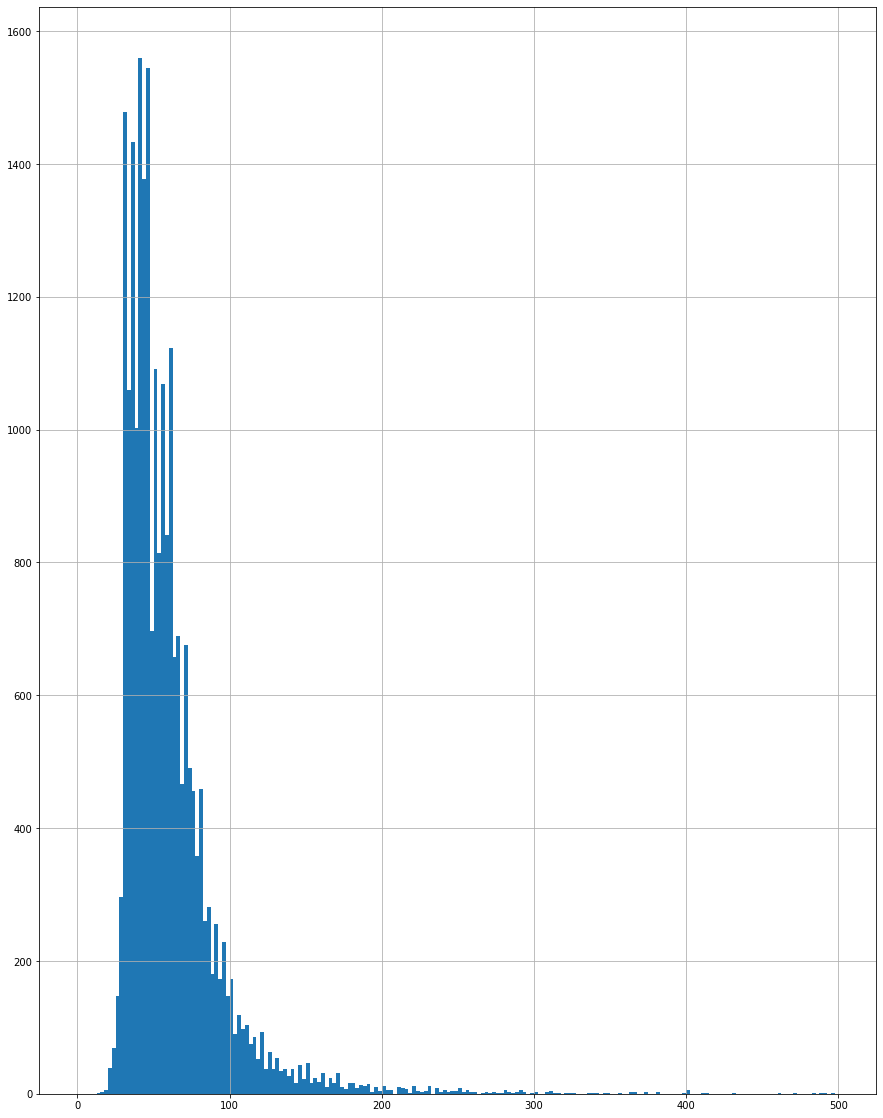

In [79]:
data['total_area'].hist(figsize=(15,20 ), bins=200,grid=True, range=(0,500))

Основная масса продаваемых квартир имеет небольшую площадь - до 50 кв.метров

Рассмотрим гистограмму жилой площади

<AxesSubplot:>

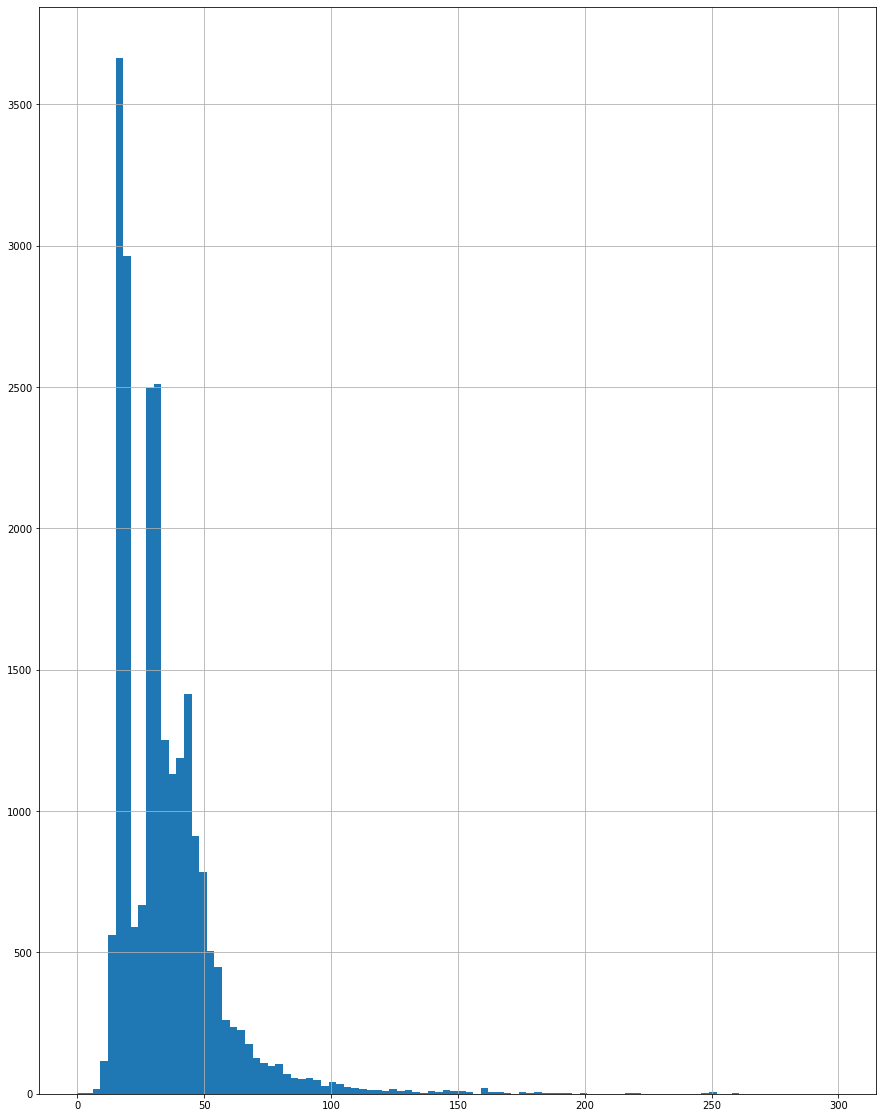

In [80]:
data['living_area'].hist(figsize=(15,20 ), bins=100,grid=True,range=(0,300))

Жилая площадь большинства квартир не превышает 40 кв.меров. При этом максимальные пиковые значения имеют площади в промежутке от 10 до 20 кв.метров и от 25 до 35 кв. метров

Рассмотрим гистограмму площади кухни

<AxesSubplot:>

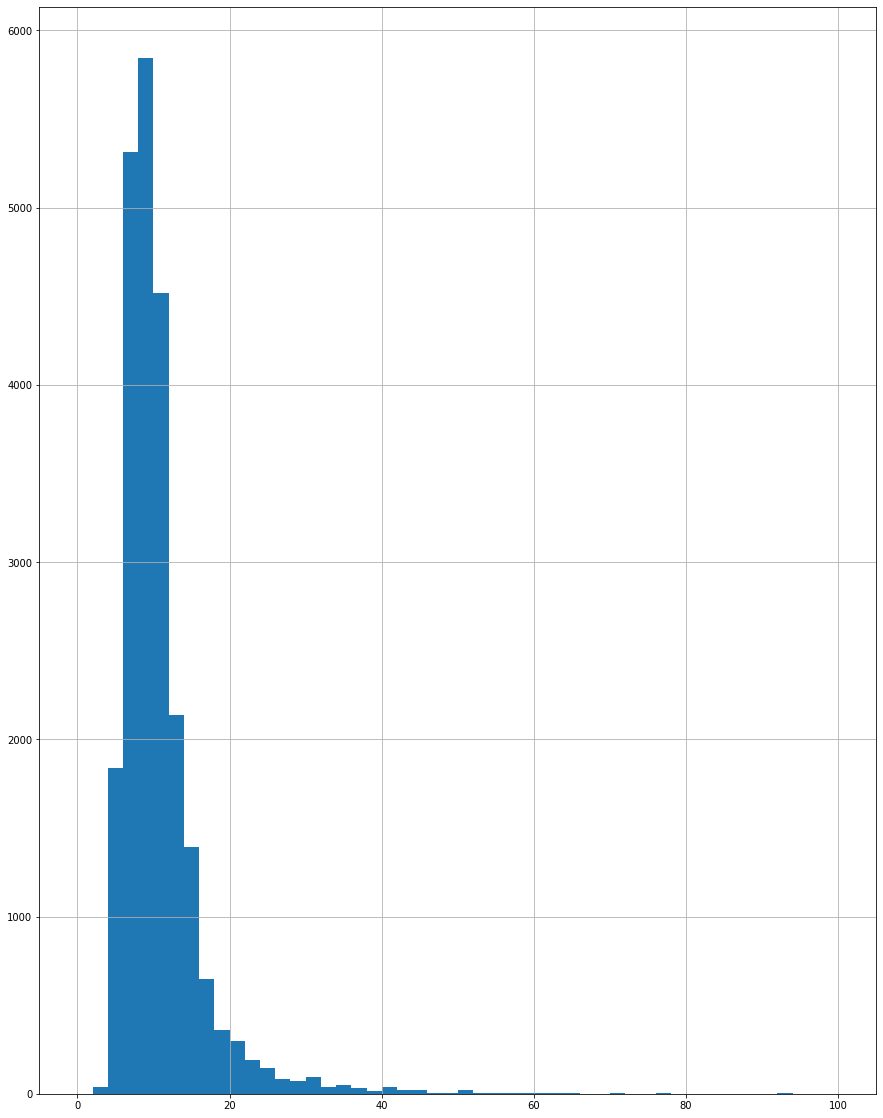

In [81]:
data['kitchen_area'].hist(figsize=(15,20 ), bins=50,grid=True,range=(0,100))

Для большинства квартир площадь кухни не превышает 12 кв. метров

Рассмотрим гистограмму цен объектов

<AxesSubplot:>

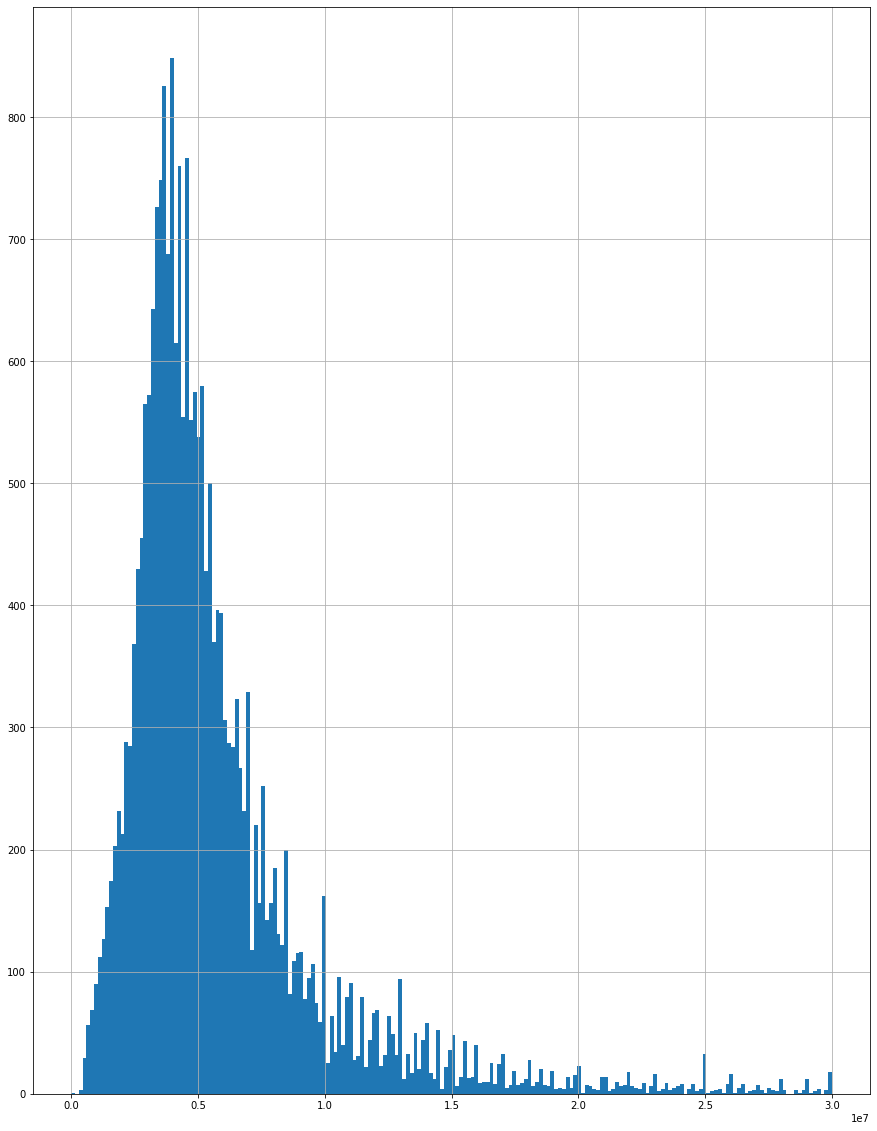

In [82]:
data['last_price'].hist(figsize=(15,20 ), bins=200,grid=True, range=(0,30000000))

Большинство предлагаемых квартир стоят до 10 млн, при том основная масса квартир стоит в районе 3-5 млн.

Рассмотрим гистограмму количества комнат

<AxesSubplot:>

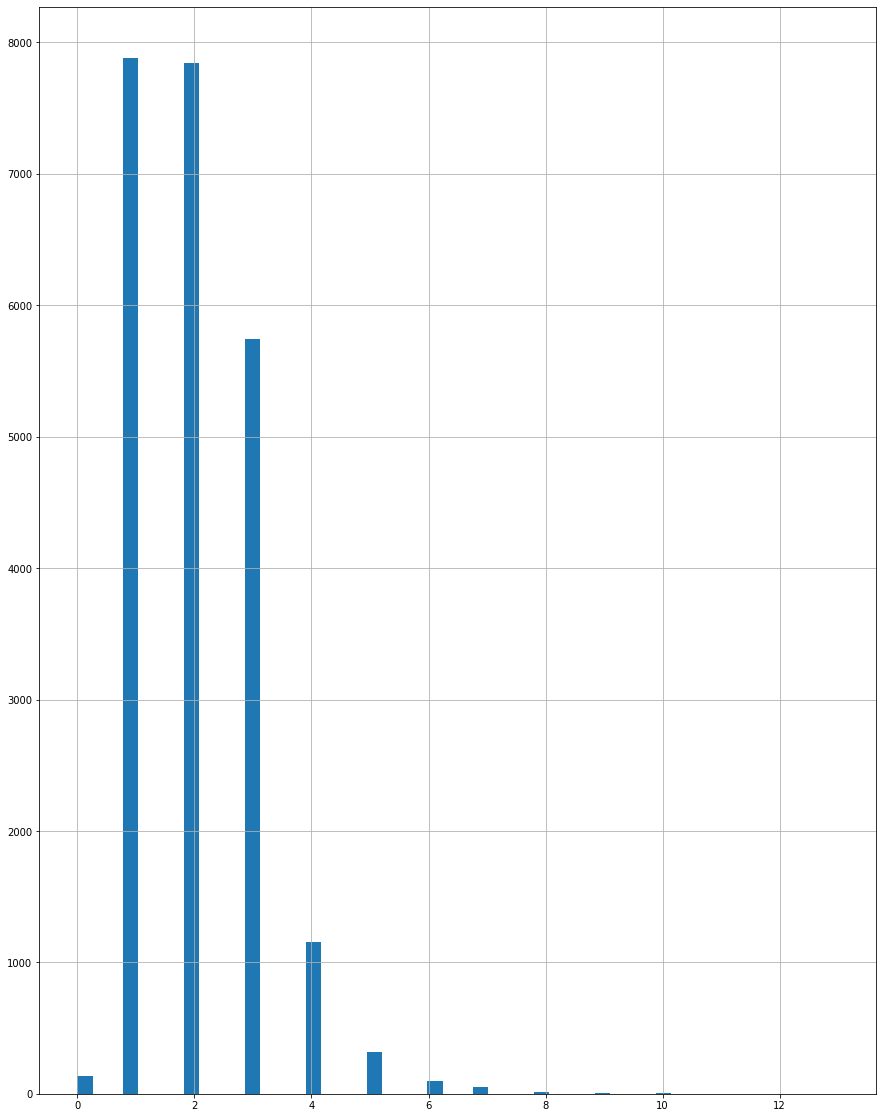

In [83]:
data['rooms'].hist(figsize=(15,20), bins=50,grid=True, range=(0,13))

Чаще всего на продажу выставляют одно- и двухкомнатные квартиры

Рассмотрим гистограмму высот потолков в квартирах

<AxesSubplot:>

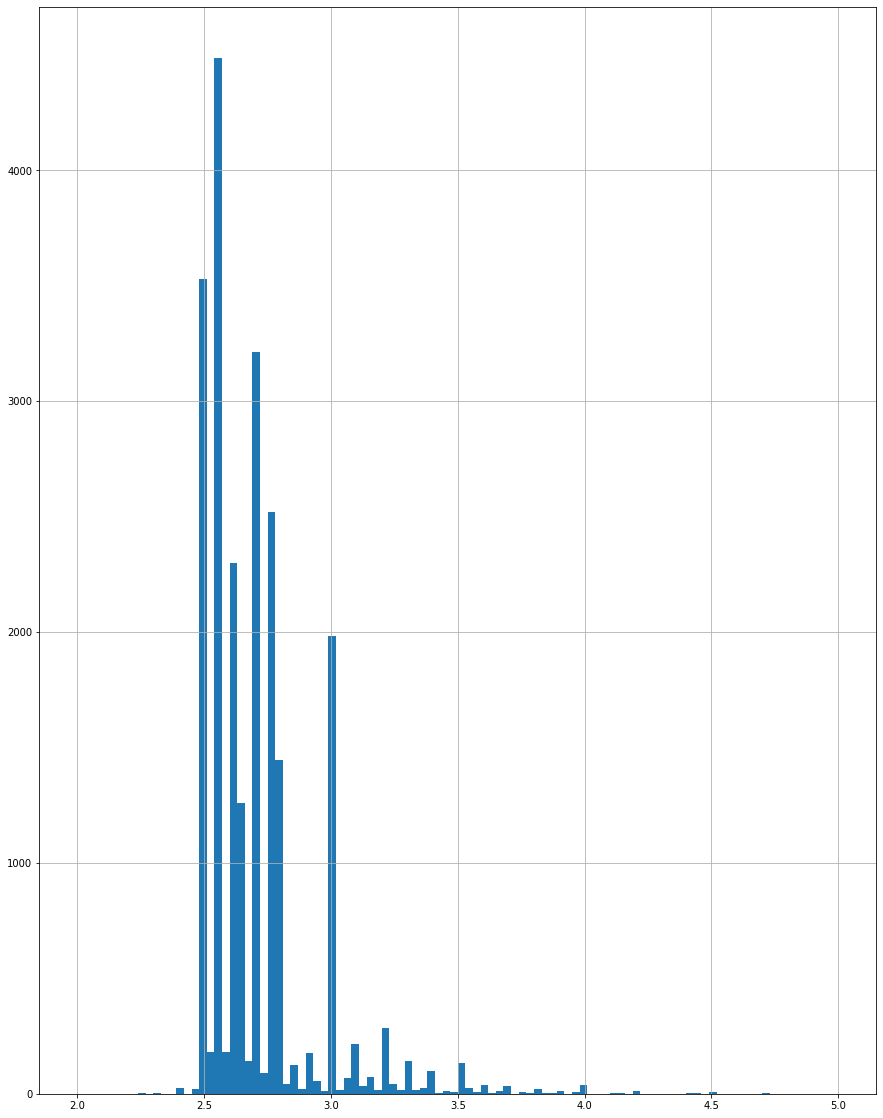

In [84]:
data['ceiling_height'].hist(figsize=(15,20), bins=100,grid=True, range=(2,5))

В среднем высота потолков в продаваемых квартирах не превышает 3 м, чаще всего варьируется от 2,5 до 2,8 м

Рассмотрим гистограмму типажей этажей квартир

<AxesSubplot:>

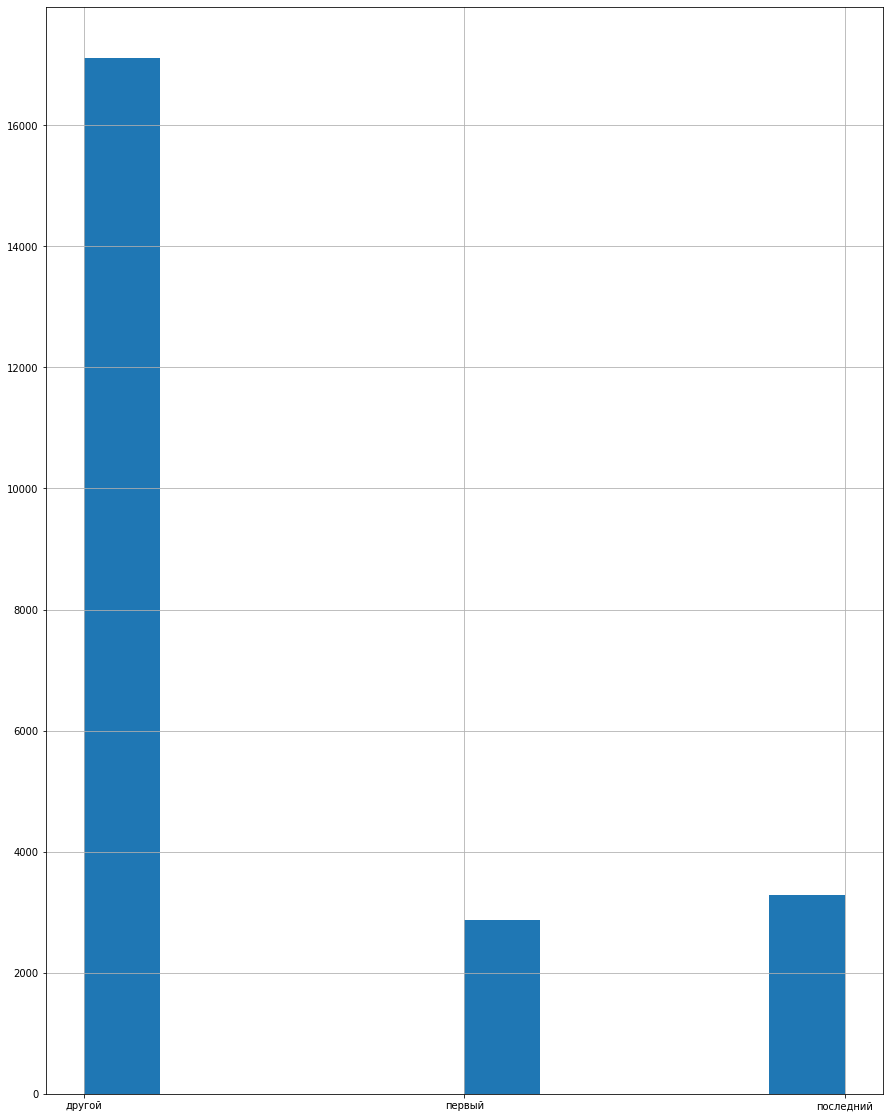

In [85]:
data['fl_type'].hist(figsize=(15,20 ), bins=10,grid=True)

Чаще всего на продажу выставляют квартиры, расположенные не на первом и не на последнем этаже. Далее идут квартиры на последних этажах. Вероятно, квартир на первом этаже продаётся меньше, т.к. часть их были переоборудованы под нежеые помещения. 

Рассмотрим гистограмму распределения предложений о продаже по количеству этажей в здании

<AxesSubplot:>

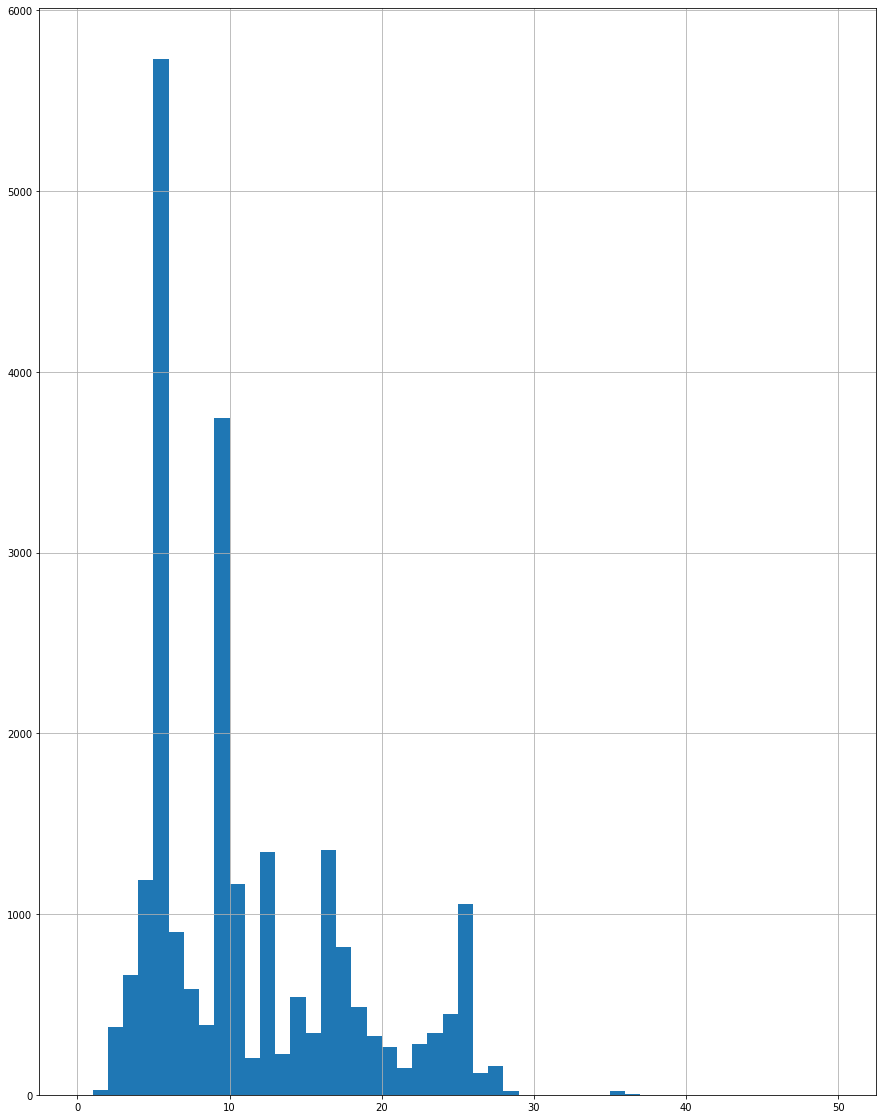

In [86]:
data['floors_total'].hist(figsize=(15,20 ), bins=50,grid=True, range=(0,50))

Чаще всего продаются квартиры, расположенные в домах высотой до 6 этажей

Рассмотрим гистограмму с расстоянием до центра города в метрах

<AxesSubplot:>

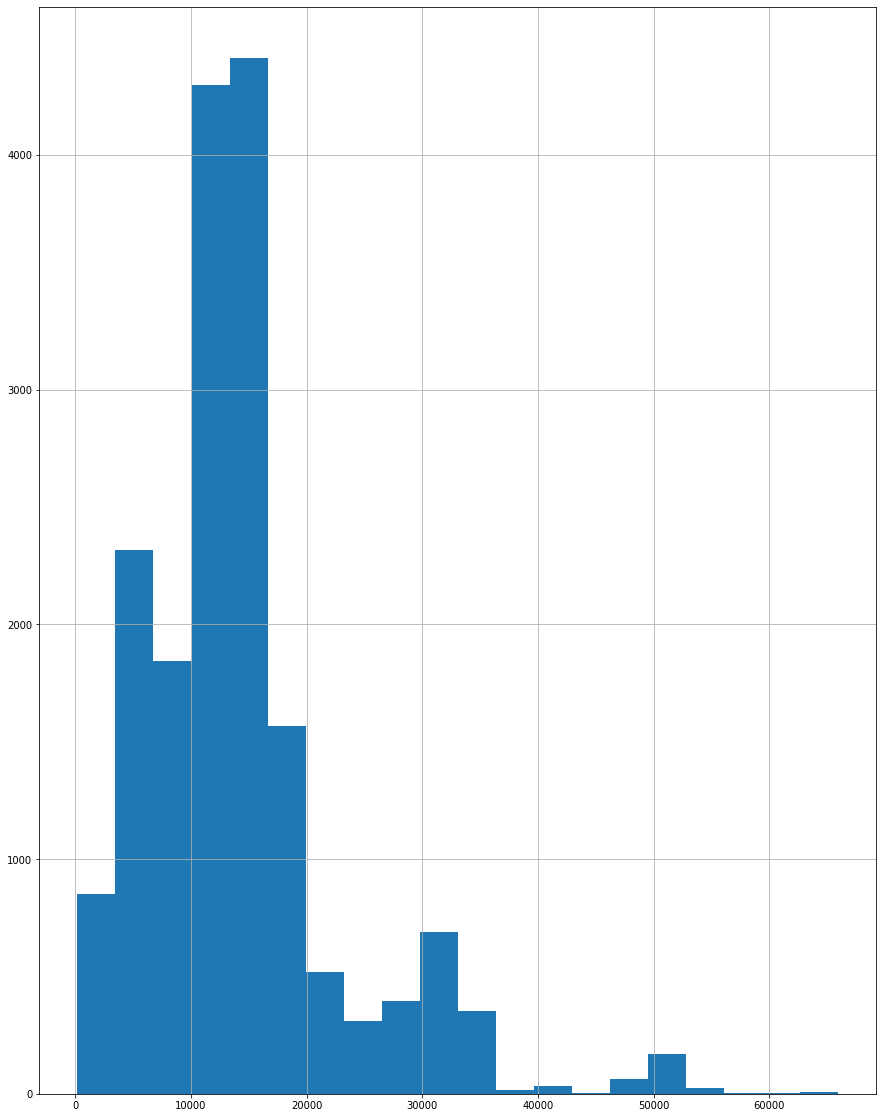

In [87]:
data[data['cityCenters_nearest'].isna()==False]['cityCenters_nearest'].hist(figsize=(15,20 ), bins=20,grid=True)

Было:Основная масса продаваемых квартир подразделяется на 2 типа близости от центра - в пределах 10 000 м и в пределах 20 000 м
Новый вывод:Основная масса продаваемых квартир продаётся на расстоянии от 10 000 до 20 000 м от центра города

Рассмотрим гистограмму с расстоянием до ближайшего парка

<AxesSubplot:>

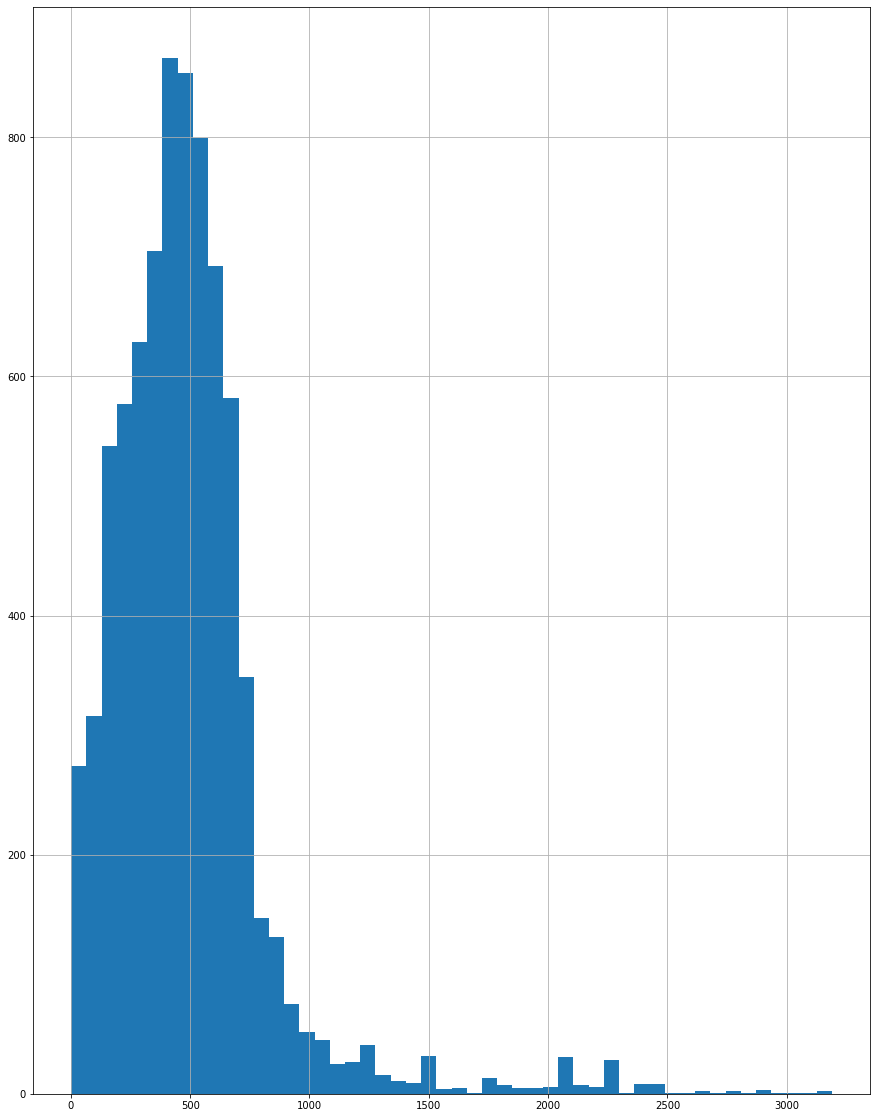

In [88]:
data[data['parks_nearest'].isna()==False]['parks_nearest'].hist(figsize=(15,20), bins=50,grid=True)

Было: В среднем парки находятся недалеко от продаваемоой недвижимости
Стало: Среднее расстояния до ближайшего парка среди объявлений о продажи составляет от 400 до 600 м

Построим гистограмму и график формата "ящик с усами" для показателя дней продажи квартир

<AxesSubplot:>

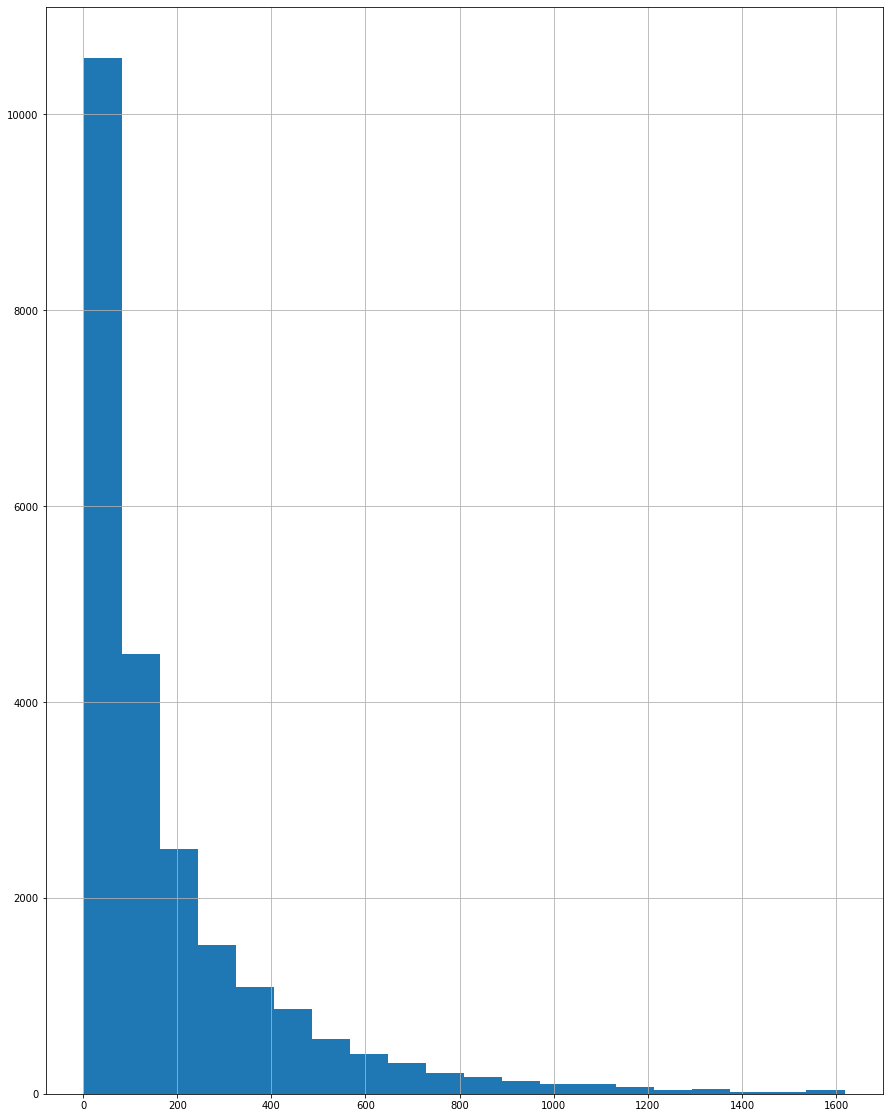

In [89]:
data['days_exposition'].hist(figsize=(15,20), bins=20,grid=True)

(0.0, 1700.0)

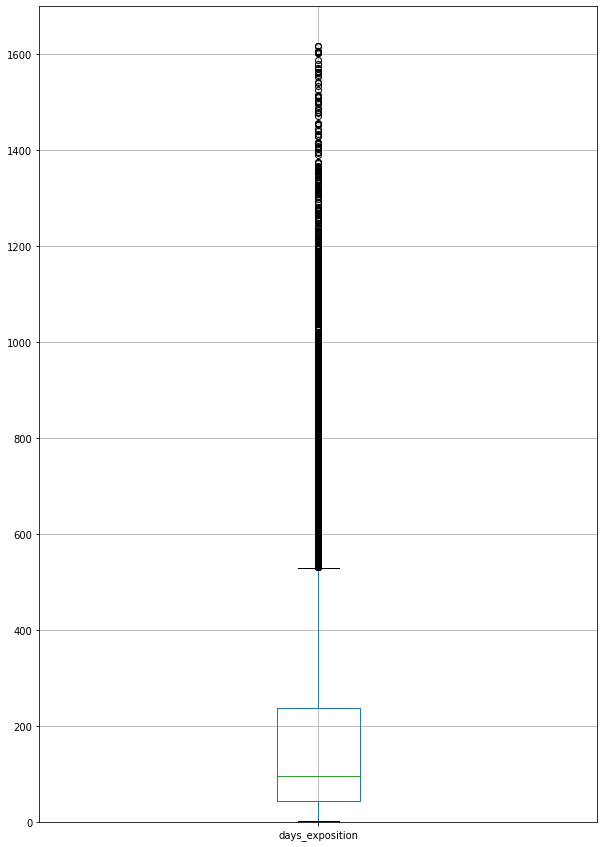

In [90]:
data.boxplot('days_exposition',figsize=(10,15))
plt.ylim(0,1700)

In [91]:
data['days_exposition'].describe()

count    23265.000000
mean       186.289319
std        233.743375
min          1.000000
25%         43.000000
50%         95.000000
75%        238.000000
max       1618.000000
Name: days_exposition, dtype: float64

Максимальный срок, в течении которого продавались квартиры составляет 1618 дней, минимальный срок продажи картиры - 1 день.
Средний срок продажи квартиры составляет 95 дней, при этом медианный срок значительно меньше и составляет 186 дней.
Границы "нормальных" сроков продажи квартир соответствуют "усам" и находятся в пределах от 1 до 530 дней.
При этом продажи от 1 до 43 дней можно считать быстрыми, а в период от 238 до 530 дней - медленными. Остальные продажи выбиваются из общей средней статистики.

Выведем отдельно только "хорошие" показатели

In [92]:
good_data=data[(data['days_exposition']>=1)&(data['days_exposition']<=530)]

К комментарию выше - изменил на актуальные

Проверим количество отсеянных строк

In [93]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21346 entries, 0 to 23263
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21346 non-null  int64         
 1   last_price            21346 non-null  int64         
 2   total_area            21346 non-null  float64       
 3   first_day_exposition  21346 non-null  datetime64[ns]
 4   rooms                 21346 non-null  int64         
 5   ceiling_height        21346 non-null  float64       
 6   floors_total          21346 non-null  int64         
 7   living_area           21346 non-null  float64       
 8   floor                 21346 non-null  int64         
 9   is_apartment          21346 non-null  bool          
 10  studio                21346 non-null  bool          
 11  open_plan             21346 non-null  bool          
 12  kitchen_area          21346 non-null  float64       
 13  balcony         

Из 23265 осталось 21346 строк с нормализованными значениями. В дальнейшем будем использовать их как более корректные.

Построим график зависимости цены от общей площади

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

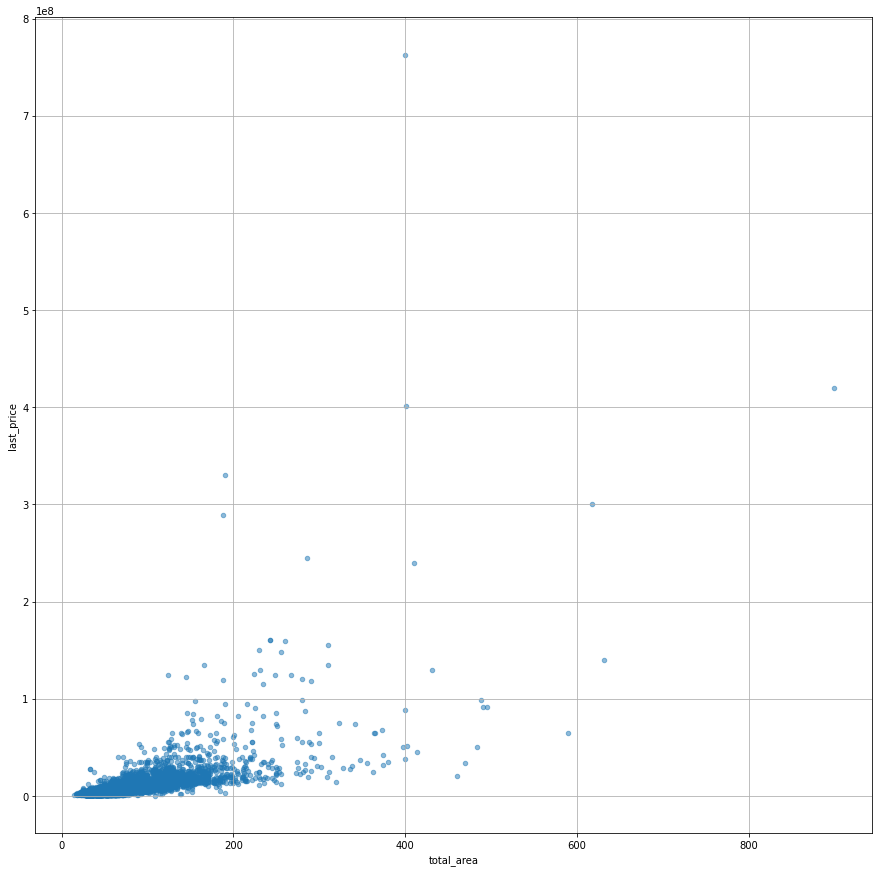

In [94]:
good_data.sort_values('total_area').plot(x='total_area', y='last_price', kind='scatter', grid=True, figsize=(15,15),alpha=0.5) 

In [95]:
good_data['total_area'].corr(good_data['last_price'])

0.6287588204263004

Цена квартиры напрямую зависит от её общей площади
Коэффициент корреляции по Пирсону в данном случае высок, что подтверждает вывод

Построим график зависимости цены от жилой площади

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

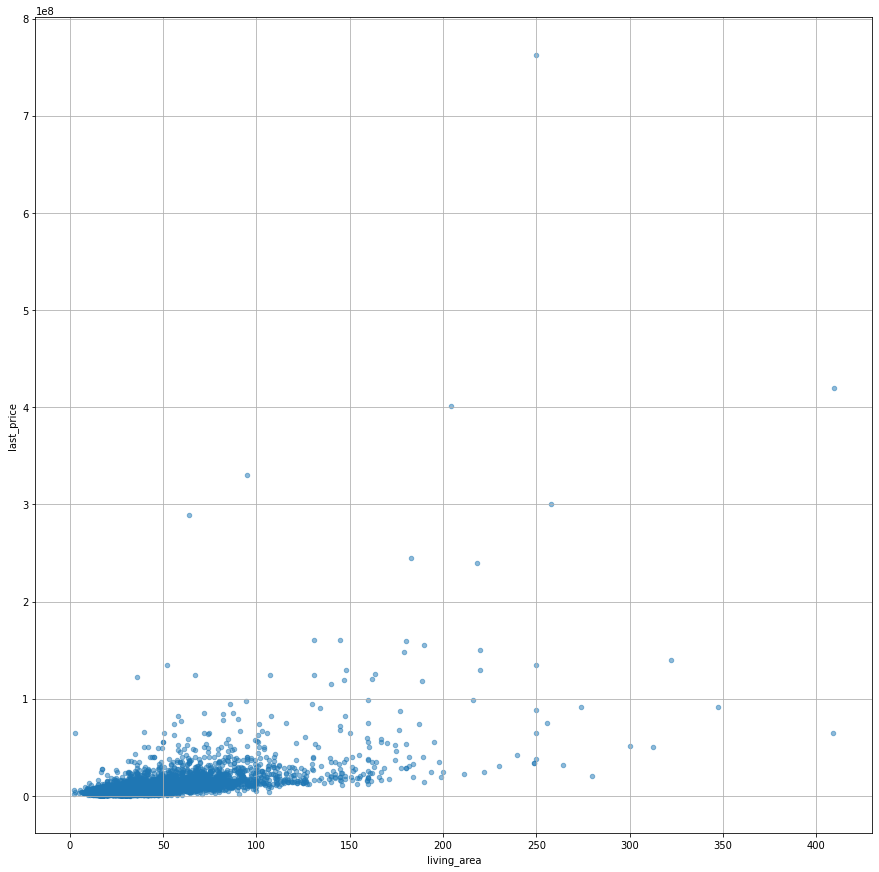

In [96]:
good_data.sort_values('living_area').plot(x='living_area', y='last_price', kind='scatter', grid=True, figsize=(15,15),alpha=0.5) 

In [97]:
good_data['living_area'].corr(good_data['last_price'])

0.5506818611825204

В большинстве случаев цена квартиры напрямую зависит от жилой площади
С ориентацией я на коэффициент корреляции Пирсона можно добавить, что жилая площадь оказывает меньшее влияние на цену квартиры, чем общая.

Построим график зависимости цены от площади кухни

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

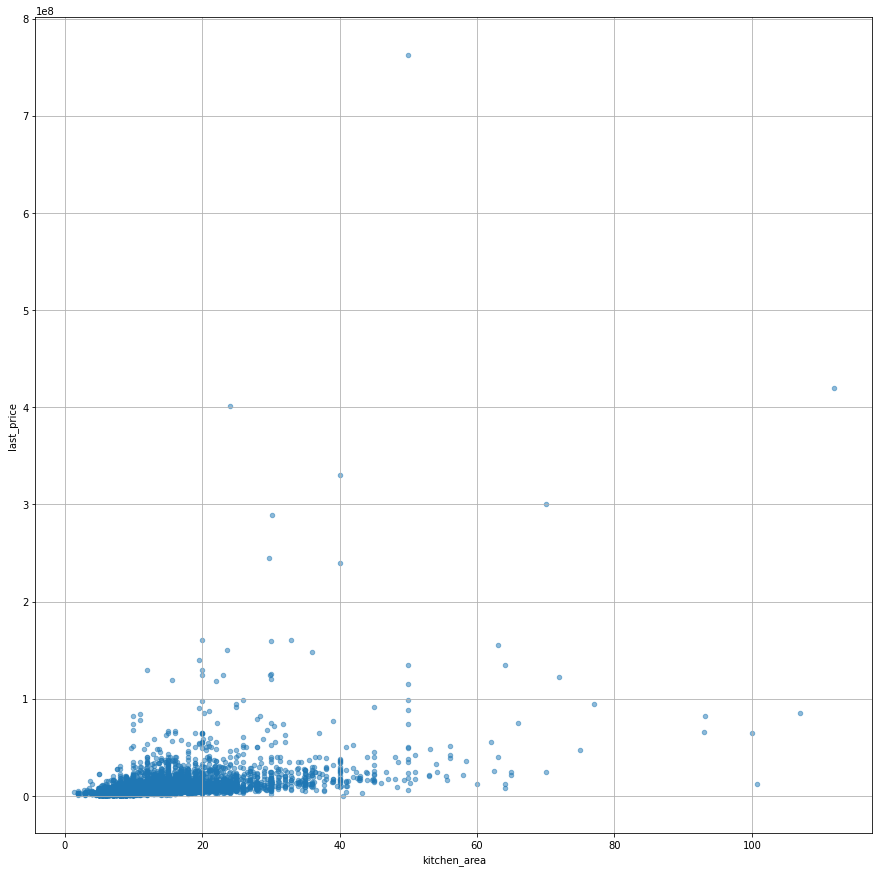

In [98]:
good_data.sort_values('kitchen_area').plot(x='kitchen_area', y='last_price', kind='scatter', grid=True, figsize=(15,15),alpha=0.5) 

In [99]:
good_data['kitchen_area'].corr(good_data['last_price'])

0.4651720975943004

Площадь кухни слабо влияет на цену квартиры, однако вляние данного показателя слабее, чем двух, описаннных выше
Это подтверждается низким, по сравнению с другими, показателями корреляции Пирсона

Построим график зависимости цены от количества комнат

<AxesSubplot:xlabel='rooms'>

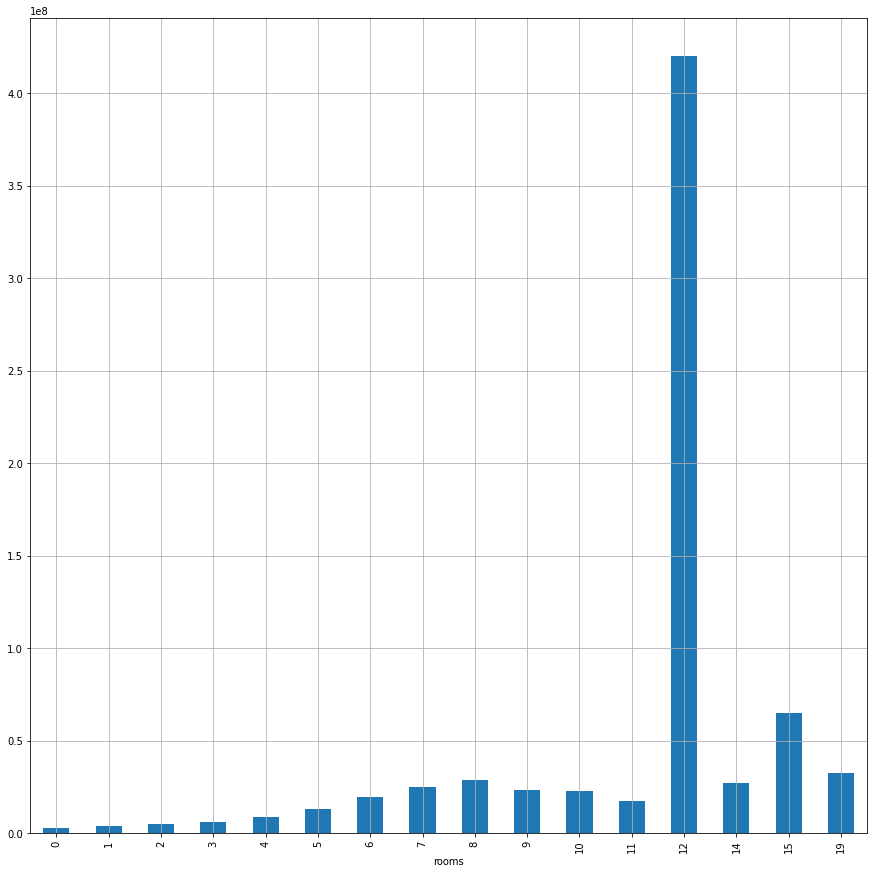

In [100]:
good_data.groupby('rooms')['last_price'].median().plot(kind='bar', grid=True, figsize=(15,15),alpha=1) 

Стоимость квартиры зависит от количества комнат

Построим график зависимости цены от типа этажа

<AxesSubplot:xlabel='fl_type'>

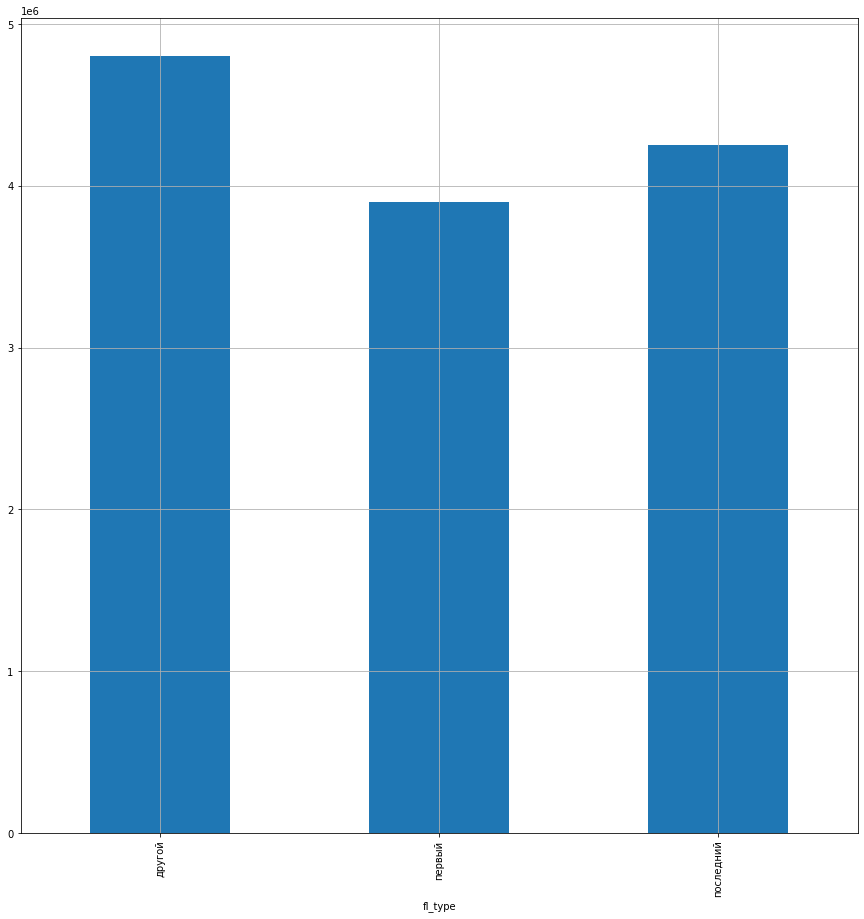

In [101]:
good_data.groupby('fl_type')['last_price'].median().plot(kind='bar', grid=True, figsize=(15,15),alpha=1) 

Средняя цена на квартиры, расположенные не на "крайних" этажах выше. На первых этажах квартиры, в среднем, стоят дешевле всего

Построим график зависимости цены от дня размещения

<AxesSubplot:xlabel='exposition_week_day'>

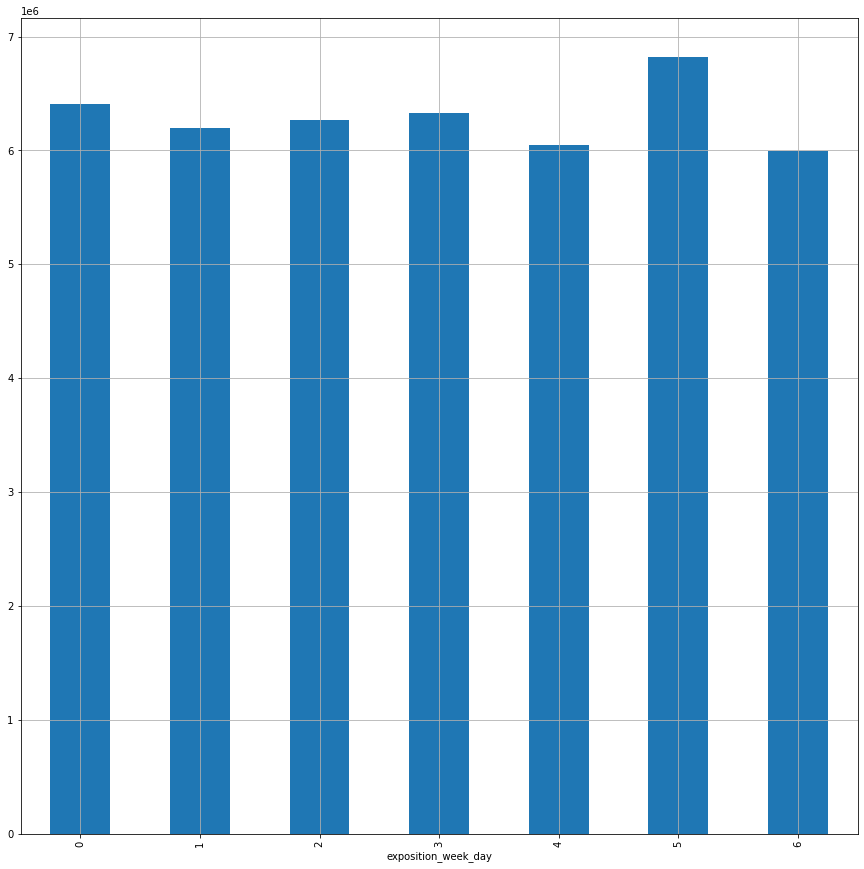

In [102]:
good_data.groupby('exposition_week_day')['last_price'].mean().plot(kind='bar', grid=True, figsize=(15,15),alpha=1) 

Цены, в зависимости ото дня, варьируются не сильно, однако, есть явное "тяготение" к более высоким ценам при размещении объявлений в субботу

Построим график зависимости цены от месяца размещения

<AxesSubplot:xlabel='exposition_month'>

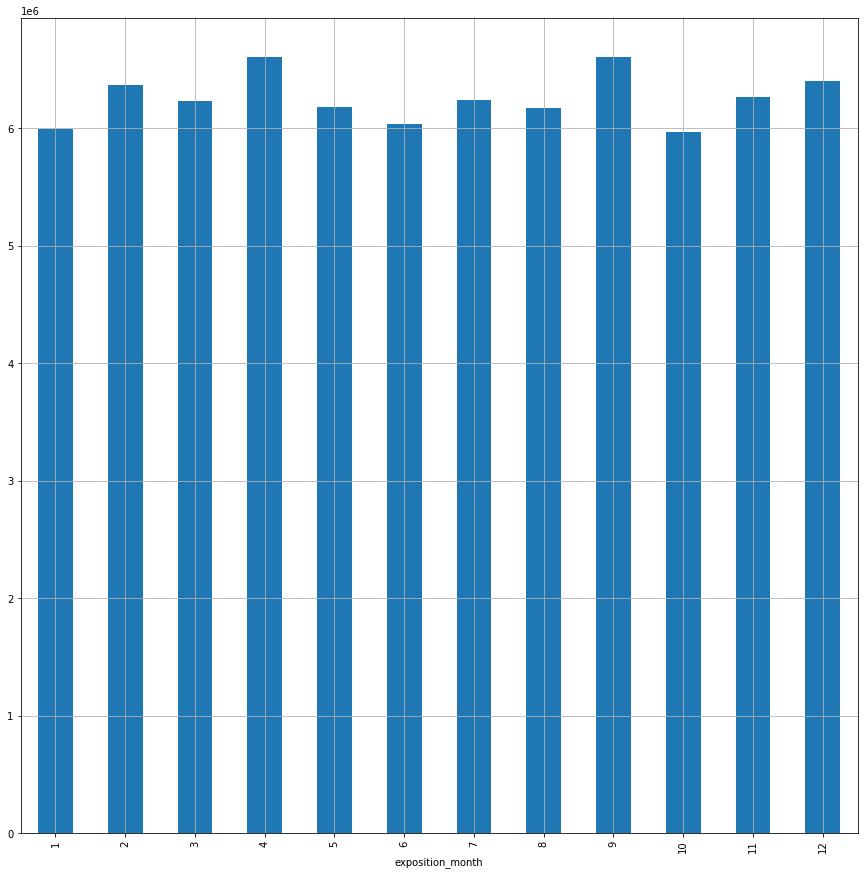

In [103]:
good_data.groupby('exposition_month')['last_price'].mean().plot(kind='bar', grid=True, figsize=(15,15),alpha=1) 

Цены, в зависимости от месяца, варьируются. В апреле и в сентябре ценыы выше, чем в среднем по году.

Построим график зависимости цены от года размещения

<AxesSubplot:xlabel='exposition_year'>

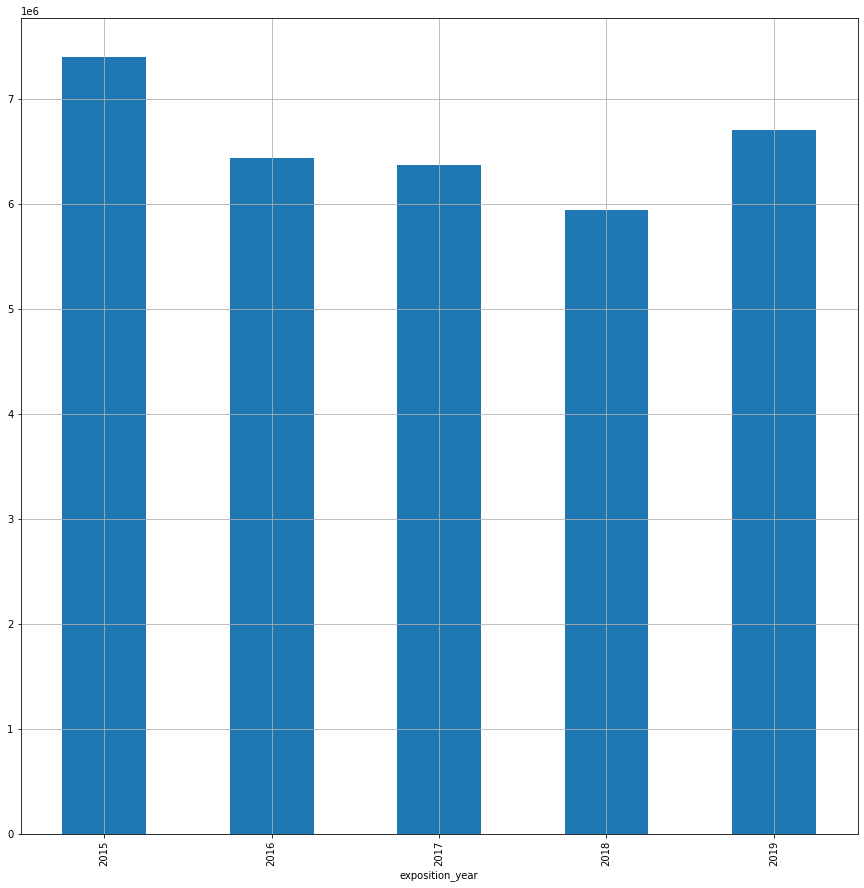

In [104]:
good_data.groupby('exposition_year')['last_price'].mean().plot(kind='bar', grid=True, figsize=(15,15),alpha=1) 

В 2015 наблюдается максимум цен на квартиры. Минимальные цены были в 2018 году

Посчитаем количество объявлений в каждом населённом пункте и создадим список с топ 10 населённых пунктов.

In [105]:
sells_counts=good_data.groupby('locality_name')['rooms'].count().sort_values(ascending=False).head(10)

In [106]:
sells_counts

locality_name
Санкт-Петербург    14136
Мурино               517
Шушары               420
Кудрово              416
Всеволожск           356
Пушкин               326
Колпино              322
Парголово            312
Гатчина              280
Выборг               219
Name: rooms, dtype: int64

In [107]:
good_data_stat=good_data.query('locality_name in @sells_counts.index')

In [108]:
good_data_stat_pivot=good_data_stat.pivot_table(index='locality_name', values=['last_price','total_area'] , aggfunc='sum')

In [109]:
good_data_stat_pivot

,last_price,total_area
locality_name,,
Всеволожск,1361358965,20134.50
Выборг,713963000,12311.46
Гатчина,975903360,14182.22
Колпино,1277762246,17182.56
Кудрово,1853460457,19717.49
Мурино,1927469706,23102.44
Парголово,1397965309,15961.95
Пушкин,2030517364,19409.39
Санкт-Петербург,108638793281,886836.83


In [110]:
good_data_stat_pivot['price_sqm']=round(good_data_stat_pivot['last_price']/good_data_stat_pivot['total_area'],0)

In [111]:
good_data_stat_pivot=good_data_stat_pivot.sort_values('price_sqm', ascending=False)

In [112]:
good_data_stat_pivot

,last_price,total_area,price_sqm
locality_name,,,
Санкт-Петербург,108638793281,886836.83,122501.0
Пушкин,2030517364,19409.39,104615.0
Кудрово,1853460457,19717.49,94001.0
Парголово,1397965309,15961.95,87581.0
Мурино,1927469706,23102.44,83431.0
Шушары,1730756999,22697.36,76254.0
Колпино,1277762246,17182.56,74364.0
Гатчина,975903360,14182.22,68812.0
Всеволожск,1361358965,20134.50,67613.0


Из 10 населённых пунктов с самым большим количеством объявлений, наибольшая средняя цена за 1 кв.м в "Санкт-Петербурге" - 122 380 рублей за 1 м2, наименьшая - в Выборге - 57 992 рубля за 1 м2

Определим зависимость средней стоимости продажи квартиры от удалённости от центра Санкт-Петербурга

In [113]:
spb_price=good_data.query('locality_name == "Санкт-Петербург"').pivot_table(index='to_ct', values='last_price' , aggfunc='mean')

In [114]:
spb_price

,last_price
to_ct,
0.0,2.949909e+07
1.0,2.259383e+07
2.0,1.755029e+07
3.0,1.070704e+07
4.0,1.281322e+07
5.0,1.358054e+07
6.0,1.421581e+07
7.0,1.317240e+07
8.0,9.765809e+06


<AxesSubplot:xlabel='to_ct'>

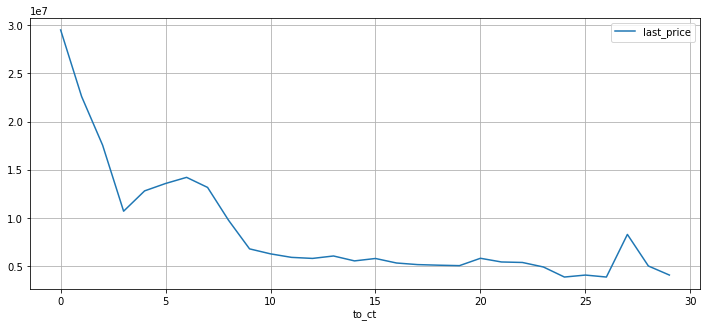

In [115]:
spb_price.plot(grid=True, figsize=(12, 5))

В зависимости от удалённости от центра города в большинстве случаев стоимость объектов снижается. Однако, есть "пики роста" на расстонии 6 и 27 км от центра.

    В результате проведенного исследоования было выявлено:
    - Большинство квартир имеют небольшую общую площадь - до 50 кв. метров
    - Жилая площадь большинства квартир не превышает 40 кв.меров. При этом максимальные пиковые значения имеют площади в промежутке от 10 до 20 кв.метров и от 25 до 35 кв. метров
    - Для большинства квартир площадь кухни не превышает 12 кв. метров
    - Большинство предлагаемых квартир стоят до 10 млн, при том основная масса квартир стоит в районе 3-5 млн.
    - Чаще всего на продажу выставляют одно- и двухкомнатные квартиры
    - В среднем высота потолков в продаваемых квартирах не превышает 3 м, чаще всего варьируется от 2,5 до 2,8 м
    - Чаще всего на продажу выставляют квартиры, расположенные не на первом и не на последнем этаже. Далее идут квартиры на последних этажах. Вероятно, квартир на первом этаже продаётся меньше, т.к. часть их были переоборудованы под нежелые помещения. 
    -Чаще всего продаются квартиры, расположенные в домах высотой до 6 этажей
    - Основная масса продаваемых квартир продаётся на расстоянии от 10 000 до 20 000 м от центра города
    - Среднее расстояния до ближайшего парка среди объявлений о продажи составляет от 400 до 600 м
    В ходе анализа было выявлено, что максимальный срок, в течении которого продавались квартиры составляет 1618 дней, минимальный срок продажи картиры - 1 день.
    Средний срок продажи квартиры составляет 95 дней, при этом медианный срок значительно меньше и составляет 186 дней.
    Границы "нормальных" сроков продажи квартир соответствуют "усам" и находятся в пределах от 1 до 530 дней.
    При этом продажи от 1 до 43 дней можно считать быстрыми, а в период от 238 до 530 дней - медленными. Остальные продажи выбиваются из общей средней статистики.
    В ходе исследования был расмотрен ряд зависимостей между показателями. Получены следующие результаты:
    -Цена квартиры напрямую зависит от её общей площади.Коэффициент корреляции по Пирсону в данном случае высок (0,63) что подтверждает вывод
    -В большинстве случаев цена квартиры напрямую зависит от жилой площади. С ориентацией я на коэффициент корреляции Пирсона (0,55) можно добавить, что жилая площадь оказывает меньшее влияние на цену квартиры, чем общая.
    -Площадь кухни слабо влияет на цену квартиры, однако вляние данного показателя слабее, чем двух, описаннных выше. Это подтверждается низким, по сравнению с другими, показателями корреляции Пирсона (0,47)
    -Стоимость квартиры зависит от количества комнат
    -Средняя цена на квартиры, расположенные не на "крайних" этажах выше. На первых этажах квартиры, в среднем, стоят дешевле всего
    -Цены, в зависимости ото дня, варьируются не сильно, однако, есть явное "тяготение" к более высоким ценам при размещении объявлений в субботу 
    -Цены, в зависимости от месяца, варьируются. В апреле и в сентябре ценыы выше, чем в среднем по году.
    -В 2015 наблюдается максимум цен на квартиры. Минимальные цены были в 2018 году
    В ходе исследования были определены ТОП-10 пунктов с самым большим количеством объявлений. В результате, из 10 населённых пунктов с самым большим количеством объявлений,  наибольшая средняя цена за 1 кв.м в "Санкт-Петербурге" - 122 380 рублей за 1 м2, наименьшая - в Выборге - 57 992 рубля за 1 м2
    При этом, в зависимости от удалённости от центра города Санкт-Петербург, в большинстве случаев стоимость объектов недвижимости, предлагаемых в нём, снижается. Однако, есть "пики роста" на расстонии 6 и 27 км от центра.

### Напишите общий вывод

    Перед началом анализа, была произведена предобработка данных исходного датасета. Восстановлены пропущенные значения там, где это возможно, а также проверены форматы данных на корректность. Помимо этого были приведены в единый вид названия локаций. В результате после очистки:
    -Количество строк датасета сократилось с 23699 строк до 23265. Таким образом, на этапе предподготовки данных было удалено 434 значения (1.8%) от исходных данных.
    -Скорректировано количество названий путём приведения их к единому виду с 364 до 304 (на 60 названий или 16% от первоначального).
    Были добавлены столбцы, более детально характеризующие продаваемую недвиимость:
    - Цена за 1 кв.м
    - День, месяц и год публикации объявления
    - Классификация по типу этажа
    - Расстояние до центра города в километрах
    На основании обновлённого варианта датасета был проведён исследовательский анализ данных. В результате было выявлено:
    - Большинство квартир имеют небольшую общую площадь - до 50 кв. метров
    - Жилая площадь большинства квартир не превышает 40 кв.меров. При этом максимальные пиковые значения имеют площади в промежутке от 10 до 20 кв.метров и от 25 до 35 кв. метров
    - Для большинства квартир площадь кухни не превышает 12 кв. метров
    - Большинство предлагаемых квартир стоят до 10 млн, при том основная масса квартир стоит в районе 3-5 млн.
    - Чаще всего на продажу выставляют одно- и двухкомнатные квартиры
    - В среднем высота потолков в продаваемых квартирах не превышает 3 м, чаще всего варьируется от 2,5 до 2,8 м
    - Чаще всего на продажу выставляют квартиры, расположенные не на первом и не на последнем этаже. Далее идут квартиры на последних этажах. Вероятно, квартир на первом этаже продаётся меньше, т.к. часть их были переоборудованы под нежелые помещения. 
    -Чаще всего продаются квартиры, расположенные в домах высотой до 6 этажей
    - Основная масса продаваемых квартир продаётся на расстоянии от 10 000 до 20 000 м от центра города
    - Среднее расстояния до ближайшего парка среди объявлений о продажи составляет от 400 до 600 м
    В ходе анализа было выявлено, что максимальный срок, в течении которого продавались квартиры составляет 1618 дней, минимальный срок продажи картиры - 1 день.
    Средний срок продажи квартиры составляет 95 дней, при этом медианный срок значительно меньше и составляет 186 дней.
    Границы "нормальных" сроков продажи квартир соответствуют "усам" и находятся в пределах от 1 до 530 дней.
    При этом продажи от 1 до 43 дней можно считать быстрыми, а в период от 238 до 530 дней - медленными. Остальные продажи выбиваются из общей средней статистики.
    В ходе исследования был расмотрен ряд зависимостей между показателями. Получены следующие результаты:
    -Цена квартиры напрямую зависит от её общей площади.Коэффициент корреляции по Пирсону в данном случае высок (0,63) что подтверждает вывод
    -В большинстве случаев цена квартиры напрямую зависит от жилой площади. С ориентацией я на коэффициент корреляции Пирсона (0,55) можно добавить, что жилая площадь оказывает меньшее влияние на цену квартиры, чем общая.
    -Площадь кухни слабо влияет на цену квартиры, однако вляние данного показателя слабее, чем двух, описаннных выше. Это подтверждается низким, по сравнению с другими, показателями корреляции Пирсона (0,47)
    -Стоимость квартиры зависит от количества комнат
    -Средняя цена на квартиры, расположенные не на "крайних" этажах выше. На первых этажах квартиры, в среднем, стоят дешевле всего
    -Цены, в зависимости ото дня, варьируются не сильно, однако, есть явное "тяготение" к более высоким ценам при размещении объявлений в субботу 
    -Цены, в зависимости от месяца, варьируются. В апреле и в сентябре ценыы выше, чем в среднем по году.
    -В 2015 наблюдается максимум цен на квартиры. Минимальные цены были в 2018 году
    В ходе исследования были определены ТОП-10 пунктов с самым большим количеством объявлений. В результате, из 10 населённых пунктов с самым большим количеством объявлений,  наибольшая средняя цена за 1 кв.м в "Санкт-Петербурге" - 122 380 рублей за 1 м2, наименьшая - в Выборге - 57 992 рубля за 1 м2
    При этом, в зависимости от удалённости от центра города Санкт-Петербург, в большинстве случаев стоимость объектов недвижимости, предлагаемых в нём, снижается. Однако, есть "пики роста" на расстонии 6 и 27 км от центра.